In [ ]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
5. Restart the runtime (Runtime -> Restart Runtime) for any upgraded packages to take effect


NOTE: User is responsible for checking the content of datasets and the applicable licenses and determining if suitable for the intended use.
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!pip install fiddle
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode
!pip install matplotlib>=3.3.2

## Install NeMo
# BRANCH = 'r2.0.0rc0'
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]
!pip install nemo_toolkit[asr]==2.0.0
!pip install numpy==1.26.4
# Update numba and restart (this is required to update internal numba version of Colab)

# In a conda environment, you would use the following command
# Update Numba to > 0.54
# conda install -c conda-forge numba>=0.54
# or
# conda update -c conda-forge numba>=0.54

# For pip based environments,
# Update Numba to > 0.54
import os
import signal

!pip install --upgrade numba

# This will kill the kernel, click next cell to import the latest numba
os.kill(os.getpid(), signal.SIGKILL)

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=0cd81ef0eb566352a20c016abbc76cff26dcce21fd488ac0f03dab8daa0c001c
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.8/419.8 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 102.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.2).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base
  libsox3 libwavpack1
Suggested packages:
  libsox-fmt-all
The following NEW packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.6 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstalled numba-0.60.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.10.0 requires numba<0.62.0a0,>=0.60.0, but you have numba 0.63.0 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
cuml-cu12 25.10.0 requires numba<0.62.0a0,>=0.60.0, but you have numba 0.63.0 which is incompatible.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Buffered Transducer ASR

There are many approaches to perform streaming/buffered inference for causal CTC / Transducer models. However, it is often observed that causal models sacrifice accuracy to perform streaming evaluation.

In this notebook, similar to the CTC tutorial for [Streaming ASR](https://github.com/NVIDIA/NeMo/blob/stable/tutorials/asr/Streaming_ASR.ipynb), we will tackle the challenge of buffered ASR for long-form speech recognition, but this time we will use Transducer models as the basis for ASR.

You may use this script [ASR Chunked Streaming Inference](https://github.com/NVIDIA/NeMo/blob/stable/examples/asr/asr_chunked_inference/rnnt/speech_to_text_buffered_infer_rnnt.py) to transcribe long audio files with Transducer models.

**Note**: It is highly recommended to review the ``Streaming ASR`` tutorial for a good overview of how streaming/buffered inference works for CTC models and the underlying motivation of streaming ASR itself.

------

Transducers surpass CTC models in speech recognition accuracy when greedy decoding with no LM is used. While CTC models can give better accuracy with beam search decoding and LM, large external language models are required to reach or surpass the accuracy of transducers with greedy decoding.

Moreover, the challenging autoregressive strategy of transducer decoding imposes particular challenges, which we will tackle as a topic in this tutorial.

# Prepare the dataset

We will continue to use the Librispeech dev-clean subset of [Mini Librispeech](https://www.openslr.org/31/).

In [5]:
import os

os.environ['NEMO_DISABLE_CUDA_GRAPHS'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

if not os.path.exists("scripts/get_librispeech_data.py"):
  !wget -P scripts/ https://raw.githubusercontent.com/NVIDIA/NeMo/stable/scripts/dataset_processing/get_librispeech_data.py

--2025-12-09 16:08:47--  https://raw.githubusercontent.com/NVIDIA/NeMo/stable/scripts/dataset_processing/get_librispeech_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7423 (7.2K) [text/plain]
Saving to: ‘scripts/get_librispeech_data.py’

get_librispeech_dat 100%[===================>]   7.25K  --.-KB/s    in 0s      

2025-12-09 16:08:47 (117 MB/s) - ‘scripts/get_librispeech_data.py’ saved [7423/7423]



In [6]:
# If something goes wrong during data processing, un-comment the following line to delete the cached dataset
# !rm -rf datasets/mini-dev-clean
!mkdir -p datasets/mini-dev-clean

In [7]:
!python scripts/get_librispeech_data.py \
  --data_root "datasets/mini-dev-clean/" \
  --data_sets dev_clean_2 \
  --num_workers=10 \
  --log

INFO:root:

Working on: dev_clean_2
INFO:root:Getting dev_clean_2
INFO:root:datasets/mini-dev-clean/dev_clean_2.tar.gz does not exist. Downloading ...
100% 120M/120M [00:08<00:00, 15.0MB/s]
INFO:root:Downloaded datasets/mini-dev-clean/dev_clean_2.tar.gz.
INFO:root:Extracting dev_clean_2
/content/scripts/get_librispeech_data.py:102: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(data_dir)
INFO:root:Processing dev_clean_2
100% 38/38 [00:12<00:00,  3.02it/s]
INFO:root:Done!


In [8]:
manifest = os.path.join(os.getcwd(), "datasets/mini-dev-clean/dev_clean_2.json")
print("Manifest path :", manifest)

Manifest path : /content/datasets/mini-dev-clean/dev_clean_2.json


Let's create a long audio that is about 15 minutes long by concatenating audio from dev-clean and also create the corresponding concatenated transcript.

In [9]:
import json
def concat_audio(manifest_file, final_len=3600):
    concat_len = 0
    final_transcript = ""
    with open("concat_file.txt", "w") as cat_f:
        while concat_len < final_len:
            with open(manifest_file, "r") as mfst_f:
                for l in mfst_f:
                    row = json.loads(l.strip())
                    if concat_len >= final_len:
                        break
                    cat_f.write(f"file {row['audio_filepath']}\n")
                    final_transcript += (" " + row['text'])
                    concat_len += float(row['duration'])
    return concat_len, final_transcript

In [10]:
new_duration, ref_transcript = concat_audio(manifest, 15*60)

concat_audio_path = os.path.join(os.getcwd(), "datasets/mini-dev-clean/concatenated_audio.wav")

!ffmpeg -t {new_duration} -safe 0 -f concat -i concat_file.txt -c copy -t {new_duration} {concat_audio_path} -y
print("Finished concatenating audio file!")

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

# Buffered Transducer

We will now prepare a Conformer Transducer model to set the stage for buffered inference. Conformers possess self-attention layers, which require quadratic cost in terms of memory and compute for a given audio sequence length. Self-attention naturally imposes a limit of 2-5 minute long audio clips, even on 32 GB of GPU memory. Therefore buffered inference is a prime candidate to resolve the issue of Conformer memory consumption.

**Note**: While we primarily discuss buffered ASR here, the primary difference between buffered and streaming ASR is the size of the chunk (which determines the latency of prediction). Many of the techniques here can be tested with smaller chunk and buffer sizes, therefore significantly improving latency and approach  "streaming" mode inference.

In [11]:
import torch
import nemo.collections.asr as nemo_asr
import contextlib
import gc

[NeMo W 2025-12-09 16:10:30 nemo_logging:393] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
      m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
    
[NeMo W 2025-12-09 16:10:30 nemo_logging:393] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
      m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
    
[NeMo W 2025-12-09 16:10:30 nemo_logging:393] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
      elif re.match('(flt)p?( \(default\))?$', token):
    
[NeMo W 2025-12-09 16:10:30 nemo_logging:393] /usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
      elif re.match('(dbl)p?( \(default\))?$', token):
    
[NeMo W 2025-12-09 16:10:30 nemo_logging:393] <frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is

In [8]:
# pretrained_model_name = "stt_en_conformer_transducer_large"

In [13]:
# Clear up memory
torch.cuda.empty_cache()
gc.collect()
# model = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained(pretrained_model_name)
model = nemo_asr.models.ASRModel.restore_from("/content/drive/MyDrive/FastConformer-Transducer-BPE.nemo")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'  # You can transcribe even longer samples on the CPU, though it will take much longer !
model = model.to(device)
model.freeze()

[NeMo I 2025-12-09 16:25:07 nemo_logging:381] Tokenizer SentencePieceTokenizer initialized with 9900 tokens


[NeMo W 2025-12-09 16:25:12 nemo_logging:393] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /workspace/parakeet_finetune_scripts/train_manifest_full_8.json
    sample_rate: 16000
    batch_size: 4
    shuffle: true
    num_workers: 8
    pin_memory: true
    max_duration: 30.0
    min_duration: 5
    is_tarred: false
    tarred_audio_filepaths: null
    shuffle_n: 2048
    bucketing_strategy: fully_randomized
    bucketing_batch_size: null
    
[NeMo W 2025-12-09 16:25:12 nemo_logging:393] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /workspace/parakeet_finetune_scripts/val_manifest_full_8.json
    sample_rate: 1

[NeMo I 2025-12-09 16:25:12 nemo_logging:381] PADDING: 0
[NeMo I 2025-12-09 16:25:23 nemo_logging:381] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'clamp': -1.0, 'fastemit_lambda': 0.0}
[NeMo I 2025-12-09 16:25:23 nemo_logging:381] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'clamp': -1.0, 'fastemit_lambda': 0.0}
[NeMo I 2025-12-09 16:25:23 nemo_logging:381] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'clamp': -1.0, 'fastemit_lambda': 0.0}
[NeMo I 2025-12-09 16:25:43 nemo_logging:381] Model EncDecRNNTBPEModel was successfully restored from /content/drive/MyDrive/FastConformer-Transducer-BPE.nemo.


In [14]:
# Helper for torch amp autocast
if torch.cuda.is_available():
    autocast = torch.cuda.amp.autocast
else:
    @contextlib.contextmanager
    def autocast():
        print("AMP was not available, using FP32!")
        yield

The call to transcribe() below should fail with a "CUDA out of memory" error when run on a GPU with 32 GB memory.

In [11]:
with autocast():
  if torch.cuda.is_available():
    transcript = model.transcribe([concat_audio_path], batch_size=1)[0]

AMP was not available, using FP32!


## Offline Baseline

Let us check the offline score of this model (on the individual segmented audio files) so that we have a baseline. This will evaluate if the buffered inference significantly sacrifices recognition accuracy.

Note that it is often the case that such clean audio segments will not be available (unless it is a preprocessed dataset). Still, we are lucky since we are using Librispeech, which has been nearly perfectly segmented for our use case.

------

Let's download some scripts from the NeMo repo to easily score our model on this dataset in an offline manner.

**Note**: It may take a few minutes to transcribe all the files due to network I/O on Colab. You may choose to uncomment and run the offline evaluation or continue on to the next cell.

In [14]:
if not os.path.exists("scripts/transcribe_speech.py"):
  !wget -P scripts/ https://raw.githubusercontent.com/NVIDIA/NeMo/stable/examples/asr/transcribe_speech.py

if not os.path.exists("scripts/speech_to_text_eval.py"):
  !wget -P scripts/ https://raw.githubusercontent.com/NVIDIA/NeMo/stable/examples/asr/speech_to_text_eval.py

--2025-11-27 11:40:31--  https://raw.githubusercontent.com/NVIDIA/NeMo/stable/examples/asr/transcribe_speech.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21387 (21K) [text/plain]
Saving to: ‘scripts/transcribe_speech.py’

transcribe_speech.p 100%[===================>]  20.89K  --.-KB/s    in 0.001s  

2025-11-27 11:40:31 (28.1 MB/s) - ‘scripts/transcribe_speech.py’ saved [21387/21387]

--2025-11-27 11:40:32--  https://raw.githubusercontent.com/NVIDIA/NeMo/stable/examples/asr/speech_to_text_eval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting respon

In [5]:
# # Uncomment if you want to run the evaluation in offline mode
# if torch.cuda.is_available():
#   !python scripts/speech_to_text_eval.py \
#     pretrained_name={pretrained_model_name} \
#     dataset_manifest={manifest} \
#     batch_size=32 \
#     amp=True \
#     use_cer=False
# else:
#   print("CUDA not available, decoding full dataset would take too long.")

In [11]:
# Clear up memory
torch.cuda.empty_cache()
gc.collect()

269777

## Buffer mechanism for streaming long audio files

As you will note below, audio chunking and buffering are identical steps for CTC and Transducer models. As such, we will perform the setup steps in the next cell without significant elaboration.

**Note**: For detailed information on how audio is chunked and evaluated, you should refer to the ``Streaming ASR`` tutorial.

In [16]:
#@title Setup Audio Chunk Iterator
# A simple iterator class to return successive chunks of samples
class AudioChunkIterator():
    def __init__(self, samples, frame_len, sample_rate):
        self._samples = samples
        self._chunk_len = chunk_len_in_secs*sample_rate
        self._start = 0
        self.output=True

    def __iter__(self):
        return self

    def __next__(self):
        if not self.output:
            raise StopIteration
        last = int(self._start + self._chunk_len)
        if last <= len(self._samples):
            chunk = self._samples[self._start: last]
            self._start = last
        else:
            chunk = np.zeros([int(self._chunk_len)], dtype='float32')
            samp_len = len(self._samples) - self._start
            chunk[0:samp_len] = self._samples[self._start:len(self._samples)]
            self.output = False

        return chunk

# a helper function for extracting samples as a numpy array from the audio file
import soundfile as sf
def get_samples(audio_file, target_sr=16000):
    with sf.SoundFile(audio_file, 'r') as f:
        sample_rate = f.samplerate
        samples = f.read()
        if sample_rate != target_sr:
            samples = librosa.core.resample(samples, orig_sr=sample_rate, target_sr=target_sr)
        samples = samples.transpose()
        return samples



In [17]:
import matplotlib.pyplot as plt
from IPython.display import display, Audio
import numpy as np

samples = get_samples(concat_audio_path)
sample_rate  = model.preprocessor._cfg['sample_rate']

## Batched Chunk Processor

First, we write a batched variant of the ``FeatureFrameBufferer`` that was written implicitly as part of the ``Streaming ASR`` tutorial.

The difference between the two versions is - the ``FeatureFrameBufferer`` will buffer across frames of a single sample and then loop for each sample in the dataset. The `BatchedFeatureFrameBufferer` will buffer across the dependent frames of the independent batch of samples. This significantly improves the efficiency of buffered transducer inference.

In [18]:
#@title Setup batched feature chunk bufferer

from nemo.collections.asr.parts.utils import streaming_utils
from torch.utils.data import DataLoader

class BatchedFeatureFrameBufferer(streaming_utils.BatchedFeatureFrameBufferer):
    """
    Batched variant of FeatureFrameBufferer where batch dimension is the independent audio samples.
    """

    def reset(self):
        '''
        Reset frame_history and decoder's state
        '''
        super().reset()
        self.limit_frames = [None for _ in range(self.batch_size)]

    def get_batch_frames(self):
        # Exit if all buffers of all samples have been processed
        if all(self.signal_end):
            return []

        # Otherwise sequentially process frames of each sample one by one.
        batch_frames = []
        for idx, frame_reader in enumerate(self.all_frame_reader):

            limit_frames = self.limit_frames[idx]
            try:
                if limit_frames is not None and self.buffer_number >= limit_frames:
                  raise StopIteration()

                frame = next(frame_reader)
                frame = np.copy(frame)

                batch_frames.append(frame)
            except StopIteration:
                # If this sample has finished all of its buffers
                # Set its signal_end flag, and assign it the id of which buffer index
                # did it finish the sample (if not previously set)
                # This will let the alignment module know which sample in the batch finished
                # at which index.
                batch_frames.append(None)
                self.signal_end[idx] = True

                if self.signal_end_index[idx] is None:
                    self.signal_end_index[idx] = self.buffer_number

        self.buffer_number += 1
        return batch_frames

    def set_frame_reader(self, frame_reader, idx, limit_frames=None):
        self.all_frame_reader[idx] = frame_reader
        self.signal_end[idx] = False
        self.signal_end_index[idx] = None
        self.limit_frames[idx] = limit_frames

## Batched and Buffered ASR Transducer

Next, we will build the actual buffered transducer evaluation class.


Similar to Streaming CTC models, we pick tokens corresponding to one chunk length of audio for each buffer. The chunk within each buffer is chosen such that there is equal left and right context available to the audio within the chunk.


Since this is a batched variant of the ``Streaming ASR`` tutorial, we will subclass the required method and override the parts that we need to support batching across independent samples and buffering across dependent frames per sample in the batch.

----

Due to the complexity of the code, we will hide the cell below then explain the essential sections of the code as sub-sections. If at any point you would like to review the code itself, click `Show code` below.

In [54]:
# #@title Setup batched and buffered transducer ASR code

# import librosa

# def inplace_buffer_merge(buffer, data, timesteps, model):
#     """
#     Merges the new text from the current frame with the previous text contained in the buffer.

#     The alignment is based on a Longest Common Subsequence algorithm, with some additional heuristics leveraging
#     the notion that the chunk size is >= the context window. In case this assumptio is violated, the results of the merge
#     will be incorrect (or at least obtain worse WER overall).
#     """
#     # If delay timesteps is 0, that means no future context was used. Simply concatenate the buffer with new data.
#     if timesteps < 1:
#         buffer += data
#         return buffer

#     # If buffer is empty, simply concatenate the buffer and data.
#     if len(buffer) == 0:
#         buffer += data
#         return buffer

#     # Concat data to buffer
#     buffer += data
#     return buffer


# class BatchedFrameASRRNNT(streaming_utils.FrameBatchASR):
#     """
#     Batched implementation of FrameBatchASR for RNNT models, where the batch dimension is independent audio samples.
#     """

#     def __init__(self, asr_model, frame_len=1.6, total_buffer=4.0,
#         batch_size=32, max_steps_per_timestep: int = 5, stateful_decoding: bool = False):
#         '''
#         Args:
#             asr_model: An RNNT model.
#             frame_len: frame's duration, seconds.
#             total_buffer: duration of total audio chunk size, in seconds.
#             batch_size: Number of independent audio samples to process at each step.
#             max_steps_per_timestep: Maximum number of tokens (u) to process per acoustic timestep (t).
#             stateful_decoding: Boolean whether to enable stateful decoding for preservation of state across buffers.
#         '''
#         super().__init__(asr_model, frame_len=frame_len, total_buffer=total_buffer, batch_size=batch_size)

#         # OVERRIDES OF THE BASE CLASS
#         self.max_steps_per_timestep = max_steps_per_timestep
#         self.stateful_decoding = stateful_decoding

#         self.all_alignments = [[] for _ in range(self.batch_size)]
#         self.all_preds = [[] for _ in range(self.batch_size)]
#         self.previous_hypotheses = None
#         self.batch_index_map = {
#             idx: idx for idx in range(self.batch_size)
#         }  # pointer from global batch id : local sub-batch id

#         try:
#             self.eos_id = self.asr_model.tokenizer.eos_id
#         except Exception:
#             self.eos_id = -1

#         print("Performing Stateful decoding :", self.stateful_decoding)

#         # OVERRIDES
#         self.frame_bufferer = BatchedFeatureFrameBufferer(
#             asr_model=asr_model, frame_len=frame_len, batch_size=batch_size, total_buffer=total_buffer
#         )

#         self.reset()

#     def reset(self):
#         """
#         Reset frame_history and decoder's state
#         """
#         super().reset()

#         self.all_alignments = [[] for _ in range(self.batch_size)]
#         self.all_preds = [[] for _ in range(self.batch_size)]
#         self.previous_hypotheses = None
#         self.batch_index_map = {idx: idx for idx in range(self.batch_size)}

#         self.data_layer = [streaming_utils.AudioBuffersDataLayer() for _ in range(self.batch_size)]
#         self.data_loader = [
#             DataLoader(self.data_layer[idx], batch_size=1, collate_fn=streaming_utils.speech_collate_fn)
#             for idx in range(self.batch_size)
#         ]

#         self.buffers = []

#     def read_audio_file(self, audio_filepath: list, delay, model_stride_in_secs):
#         assert len(audio_filepath) == self.batch_size

#         # Read in a batch of audio files, one by one
#         for idx in range(self.batch_size):
#             samples = get_samples(audio_filepath[idx])
#             samples = np.pad(samples, (0, int(delay * model_stride_in_secs * self.asr_model._cfg.sample_rate)))
#             frame_reader = streaming_utils.AudioFeatureIterator(samples, self.frame_len, self.raw_preprocessor, self.asr_model.device)
#             self.set_frame_reader(frame_reader, idx)

#     def set_frame_reader(self, frame_reader, idx, limit_frames = None):
#         self.frame_bufferer.set_frame_reader(frame_reader, idx, limit_frames)

#     @torch.no_grad()
#     def infer_logits(self):
#         frame_buffers = self.frame_bufferer.get_buffers_batch()

#         while len(frame_buffers) > 0:
#             # While at least 1 sample has a buffer left to process
#             self.frame_buffers += frame_buffers[:]

#             for idx, buffer in enumerate(frame_buffers):
#                 if self.plot:
#                   self.buffers.append(buffer[:][0])
#                 self.data_layer[idx].set_signal(buffer[:])

#             self._get_batch_preds()
#             frame_buffers = self.frame_bufferer.get_buffers_batch()

#     @torch.no_grad()
#     def _get_batch_preds(self):
#         """
#         Perform dynamic batch size decoding of frame buffers of all samples.

#         Steps:
#             -   Load all data loaders of every sample
#             -   For all samples, determine if signal has finished.
#                 -   If so, skip calculation of mel-specs.
#                 -   If not, compute mel spec and length
#             -   Perform Encoder forward over this sub-batch of samples. Maintain the indices of samples that were processed.
#             -   If performing stateful decoding, prior to decoder forward, remove the states of samples that were not processed.
#             -   Perform Decoder + Joint forward for samples that were processed.
#             -   For all output RNNT alignment matrix of the joint do:
#                 -   If signal has ended previously (this was last buffer of padding), skip alignment
#                 -   Otherwise, recalculate global index of this sample from the sub-batch index, and preserve alignment.
#             -   Same for preds
#             -   Update indices of sub-batch with global index map.
#             - Redo steps until all samples were processed (sub-batch size == 0).
#         """
#         device = self.asr_model.device

#         data_iters = [iter(data_loader) for data_loader in self.data_loader]

#         feat_signals = []
#         feat_signal_lens = []

#         new_batch_keys = []
#         for idx in range(self.batch_size):
#             if self.frame_bufferer.signal_end[idx]:
#                 continue

#             batch = next(data_iters[idx])
#             feat_signal, feat_signal_len = batch
#             feat_signal, feat_signal_len = feat_signal.to(device), feat_signal_len.to(device)

#             feat_signals.append(feat_signal)
#             feat_signal_lens.append(feat_signal_len)

#             # preserve batch indices
#             new_batch_keys.append(idx)

#         if len(feat_signals) == 0:
#             return

#         feat_signal = torch.cat(feat_signals, 0)
#         feat_signal_len = torch.cat(feat_signal_lens, 0)

#         del feat_signals, feat_signal_lens

#         encoded, encoded_len = self.asr_model(processed_signal=feat_signal, processed_signal_length=feat_signal_len)

#         # filter out partial hypotheses from older batch subset
#         if self.stateful_decoding and self.previous_hypotheses is not None:
#             new_prev_hypothesis = []
#             for new_batch_idx, global_index_key in enumerate(new_batch_keys):
#                 old_pos = self.batch_index_map[global_index_key]
#                 new_prev_hypothesis.append(self.previous_hypotheses[old_pos])
#             self.previous_hypotheses = new_prev_hypothesis

#         best_hyp, _ = self.asr_model.decoding.rnnt_decoder_predictions_tensor(
#             encoded, encoded_len, return_hypotheses=True, partial_hypotheses=self.previous_hypotheses
#         )

#         if self.stateful_decoding:
#             # preserve last state from hypothesis of new batch indices
#             self.previous_hypotheses = best_hyp

#         for idx, hyp in enumerate(best_hyp):
#             global_index_key = new_batch_keys[idx]  # get index of this sample in the global batch

#             has_signal_ended = self.frame_bufferer.signal_end[global_index_key]

#             if not has_signal_ended:
#                 self.all_alignments[global_index_key].append(hyp.alignments)

#         preds = [hyp.y_sequence for hyp in best_hyp]
#         for idx, pred in enumerate(preds):
#             global_index_key = new_batch_keys[idx]  # get index of this sample in the global batch

#             has_signal_ended = self.frame_bufferer.signal_end[global_index_key]
#             if not has_signal_ended:
#                 self.all_preds[global_index_key].append(pred.cpu().numpy())

#         if self.stateful_decoding:
#             # State resetting is being done on sub-batch only, global index information is not being updated
#             reset_states = self.asr_model.decoder.initialize_state(encoded)

#             for idx, pred in enumerate(preds):
#                 if len(pred) > 0 and pred[-1] == self.eos_id:
#                     # reset states :
#                     self.previous_hypotheses[idx].y_sequence = self.previous_hypotheses[idx].y_sequence[:-1]
#                     self.previous_hypotheses[idx].dec_state = self.asr_model.decoder.batch_select_state(
#                         reset_states, idx
#                     )

#         # Position map update
#         if len(new_batch_keys) != len(self.batch_index_map):
#             for new_batch_idx, global_index_key in enumerate(new_batch_keys):
#                 self.batch_index_map[global_index_key] = new_batch_idx  # let index point from global pos -> local pos

#         del encoded, encoded_len
#         del best_hyp, pred

#     # def transcribe(
#     #     self, tokens_per_chunk: int, delay: int, plot=False,
#     # ):
#     #     """
#     #     Performs "middle token" alignment prediction using the buffered audio chunk.
#     #     """
#     #     self.plot = plot
#     #     self.infer_logits()

#     #     self.unmerged = [[] for _ in range(self.batch_size)]
#     #     for idx, alignments in enumerate(self.all_alignments):

#     #         signal_end_idx = self.frame_bufferer.signal_end_index[idx]
#     #         if signal_end_idx is None:
#     #             raise ValueError("Signal did not end")

#     #         all_toks = []

#     #         for a_idx, alignment in enumerate(alignments):
#     #             # alignment = alignment[len(alignment) - 1 - delay : len(alignment) - 1 - delay + tokens_per_chunk]
#     #             ################### ADDED BY ME TO REPLACE MIDDLE TOKEN EXTRACTION ##########################
#     #             # Or try this safer middle token extraction:
#     #             if len(alignment) > 0:
#     #                 # Calculate safe indices
#     #                 total_len = len(alignment)
#     #                 start_idx = max(0, total_len - 1 - delay)
#     #                 end_idx = min(total_len, start_idx + tokens_per_chunk)
#     #                 if start_idx < end_idx:
#     #                     alignment = alignment[start_idx:end_idx]
#     #                 else:
#     #                     alignment = alignment
#     #              ############################################################################################

#     #             ids, toks = self._alignment_decoder(alignment, self.asr_model.tokenizer, self.blank_id)
#     #             all_toks.append(toks)

#     #             if len(ids) > 0 and a_idx < signal_end_idx:
#     #                 self.unmerged[idx] = inplace_buffer_merge(self.unmerged[idx], ids, delay, model=self.asr_model,)

#     #         if plot:
#     #           for i, tok in enumerate(all_toks):
#     #               print("\nGreedy labels collected from this buffer")
#     #               print(tok[len(tok) - 1 - delay:len(tok) - 1 - delay + tokens_per_chunk])
#     #               self.toks_unmerged += tok[len(tok) - 1 - delay:len(tok) - 1 - delay + tokens_per_chunk]
#     #           print("\nTokens collected from successive buffers before RNNT merge")
#     #           print(self.toks_unmerged)

#     #     output = []
#     #     for idx in range(self.batch_size):
#     #         output.append(self.greedy_merge(self.unmerged[idx]))
#         # return output

#     # In the transcribe() method, replace the problematic alignment extraction:
#     def transcribe(self, tokens_per_chunk: int, delay: int, plot=False):
#       self.plot = plot
#       self.infer_logits()

#       self.unmerged = [[] for _ in range(self.batch_size)]
#       for idx, alignments in enumerate(self.all_alignments):

#           signal_end_idx = self.frame_bufferer.signal_end_index[idx]
#           if signal_end_idx is None:
#               raise ValueError("Signal did not end")

#           all_toks = []

#       for a_idx, alignment in enumerate(alignments):
#           if len(alignment) == 0:
#               continue

#           # **FIXED MIDDLE TOKEN EXTRACTION**
#           total_timesteps = len(alignment)

#           # Calculate extraction window more carefully
#           if total_timesteps <= tokens_per_chunk:
#               # If alignment is smaller than expected, take most of it
#               start_idx = max(0, total_timesteps // 4)  # Skip first 25%
#               end_idx = total_timesteps
#           else:
#               # For larger alignments, use improved middle extraction
#               # Instead of the problematic calculation, use a simpler approach:
#               middle_start = total_timesteps // 3  # Start at 33% point
#               middle_end = min(total_timesteps, middle_start + tokens_per_chunk)
#               start_idx = middle_start
#               end_idx = middle_end

#           # Safely extract the middle portion
#           if start_idx < end_idx and start_idx < len(alignment):
#               extracted_alignment = alignment[start_idx:end_idx]
#           else:
#               extracted_alignment = alignment  # Fallback to full alignment

#           print(f"DEBUG: Total alignment: {len(alignment)}, extracted: {len(extracted_alignment)} (indices {start_idx}:{end_idx})")

#           ids, toks = self._alignment_decoder(extracted_alignment, self.asr_model.tokenizer, self.blank_id)
#           all_toks.append(toks)

#           if len(ids) > 0 and a_idx < signal_end_idx:
#               self.unmerged[idx] = inplace_buffer_merge(self.unmerged[idx], ids, delay, model=self.asr_model)

#       if plot:
#           for i, tok in enumerate(all_toks):
#               print("\nGreedy labels collected from this buffer")
#               print(tok[len(tok) - 1 - delay:len(tok) - 1 - delay + tokens_per_chunk])
#               self.toks_unmerged += tok[len(tok) - 1 - delay:len(tok) - 1 - delay + tokens_per_chunk]
#           print("\nTokens collected from successive buffers before RNNT merge")
#           print(self.toks_unmerged)

#       output = []
#       for idx in range(self.batch_size):
#           output.append(self.greedy_merge(self.unmerged[idx]))
#       return output


#     def _alignment_decoder(self, alignments, tokenizer, blank_id):
#         s = []
#         ids = []

#         for t in range(len(alignments)):
#             for u in range(len(alignments[t])):
#                 token_id = int(alignments[t][u][1])
#                 if token_id != blank_id:
#                     token = tokenizer.ids_to_tokens([token_id])[0]
#                     s.append(token)
#                     ids.append(token_id)

#                 else:
#                     # blank token
#                     pass

#         return ids, s

#     def greedy_merge(self, preds):
#         decoded_prediction = [p for p in preds]
#         hypothesis = self.asr_model.tokenizer.ids_to_text(decoded_prediction)
#         return hypothesis

In [19]:
#@title Setup batched and buffered transducer ASR code

import librosa

def inplace_buffer_merge(buffer, data, timesteps, model):
    """
    Merges the new text from the current frame with the previous text contained in the buffer.

    The alignment is based on a Longest Common Subsequence algorithm, with some additional heuristics leveraging
    the notion that the chunk size is >= the context window. In case this assumptio is violated, the results of the merge
    will be incorrect (or at least obtain worse WER overall).
    """
    # If delay timesteps is 0, that means no future context was used. Simply concatenate the buffer with new data.
    if timesteps < 1:
        buffer += data
        return buffer

    # If buffer is empty, simply concatenate the buffer and data.
    if len(buffer) == 0:
        buffer += data
        return buffer

    # Concat data to buffer
    buffer += data
    return buffer


class BatchedFrameASRRNNT(streaming_utils.FrameBatchASR):
    """
    Simplified implementation that avoids complex alignment extraction
    """

    def __init__(self, asr_model, frame_len=1.6, total_buffer=4.0,
        batch_size=32, max_steps_per_timestep: int = 5, stateful_decoding: bool = False):
        '''Same init as before'''
        super().__init__(asr_model, frame_len=frame_len, total_buffer=total_buffer, batch_size=batch_size)

        self.max_steps_per_timestep = max_steps_per_timestep
        self.stateful_decoding = stateful_decoding

        # Store full transcriptions instead of alignments
        self.buffer_transcriptions = [[] for _ in range(self.batch_size)]
        self.previous_hypotheses = None
        self.batch_index_map = {idx: idx for idx in range(self.batch_size)}

        try:
            self.eos_id = self.asr_model.tokenizer.eos_id
        except Exception:
            self.eos_id = -1

        print("Performing Stateful decoding :", self.stateful_decoding)

        self.frame_bufferer = BatchedFeatureFrameBufferer(
            asr_model=asr_model, frame_len=frame_len, batch_size=batch_size, total_buffer=total_buffer
        )

        self.reset()

    def reset(self):
        """Reset frame_history and decoder's state"""
        super().reset()

        self.buffer_transcriptions = [[] for _ in range(self.batch_size)]
        self.previous_hypotheses = None
        self.batch_index_map = {idx: idx for idx in range(self.batch_size)}

        self.data_layer = [streaming_utils.AudioBuffersDataLayer() for _ in range(self.batch_size)]
        self.data_loader = [
            DataLoader(self.data_layer[idx], batch_size=1, collate_fn=streaming_utils.speech_collate_fn)
            for idx in range(self.batch_size)
        ]
        self.buffers = []

    def set_frame_reader(self, frame_reader, idx, limit_frames=None):
        self.frame_bufferer.set_frame_reader(frame_reader, idx, limit_frames)

    @torch.no_grad()
    def infer_logits(self):
        frame_buffers = self.frame_bufferer.get_buffers_batch()

        while len(frame_buffers) > 0:
            self.frame_buffers += frame_buffers[:]

            for idx, buffer in enumerate(frame_buffers):
                if self.plot:
                    self.buffers.append(buffer[:][0])
                self.data_layer[idx].set_signal(buffer[:])

            self._get_batch_preds()
            frame_buffers = self.frame_bufferer.get_buffers_batch()

    @torch.no_grad()
    def _get_batch_preds(self):
        """Get full transcription of each buffer (simplified approach)"""
        device = self.asr_model.device
        data_iters = [iter(data_loader) for data_loader in self.data_loader]

        feat_signals = []
        feat_signal_lens = []
        new_batch_keys = []

        for idx in range(self.batch_size):
            if self.frame_bufferer.signal_end[idx]:
                continue

            batch = next(data_iters[idx])
            feat_signal, feat_signal_len = batch
            feat_signal, feat_signal_len = feat_signal.to(device), feat_signal_len.to(device)

            feat_signals.append(feat_signal)
            feat_signal_lens.append(feat_signal_len)
            new_batch_keys.append(idx)

        if len(feat_signals) == 0:
            return

        feat_signal = torch.cat(feat_signals, 0)
        feat_signal_len = torch.cat(feat_signal_lens, 0)

        encoded, encoded_len = self.asr_model(processed_signal=feat_signal, processed_signal_length=feat_signal_len)

        # Get full transcriptions (no complex alignment extraction)
        best_hyp, _ = self.asr_model.decoding.rnnt_decoder_predictions_tensor(
            encoded, encoded_len, return_hypotheses=False, partial_hypotheses=None
        )

        # Store full transcription of each buffer
        for idx, hyp in enumerate(best_hyp):
            global_index_key = new_batch_keys[idx]
            has_signal_ended = self.frame_bufferer.signal_end[global_index_key]

            if not has_signal_ended:
                full_text = hyp  # This is the complete transcription
                self.buffer_transcriptions[global_index_key].append(full_text)

        del encoded, encoded_len, feat_signal, feat_signal_len

    def transcribe(self, tokens_per_chunk: int, delay: int, plot=False):
        """Simple transcription with overlap removal"""
        self.plot = plot
        self.infer_logits()

        output = []
        for idx in range(self.batch_size):
            buffer_texts = self.buffer_transcriptions[idx]

            if plot:
                print("\n=== RAW BUFFER TRANSCRIPTIONS ===")
                for i, text in enumerate(buffer_texts):
                    print(f"Buffer {i}: '{text}'")

            # Remove overlaps between consecutive buffers
            final_text = self.remove_buffer_overlaps(buffer_texts)
            output.append(final_text)

        return output

    def remove_buffer_overlaps(self, buffer_texts, min_overlap_words=2):
      """Improved overlap removal with fuzzy matching"""
      if len(buffer_texts) <= 1:
          return " ".join(buffer_texts)

      print(f"\n=== OVERLAP REMOVAL DEBUG ===")

      # Start with first buffer
      result_words = buffer_texts[0].split()
      print(f"Starting with: '{' '.join(result_words)}'")

      for i in range(1, len(buffer_texts)):
          current_words = buffer_texts[i].split()

          if not current_words:
              continue

          print(f"\nBuffer {i}: '{' '.join(current_words)}'")
          print(f"Looking for overlap with: '{' '.join(result_words[-8:])}'")  # Last 8 words

          # Find overlap by checking if any suffix of result matches any prefix of current
          best_overlap = 0

          # Check from longest possible overlap down to minimum
          max_check = min(len(result_words), len(current_words), 10)  # Check up to 10 words

          for overlap_len in range(max_check, min_overlap_words - 1, -1):
              result_suffix = result_words[-overlap_len:]
              current_prefix = current_words[:overlap_len]

              # Allow for slight differences (case, punctuation)
              result_clean = [w.lower().strip('.,!?') for w in result_suffix]
              current_clean = [w.lower().strip('.,!?') for w in current_prefix]

              if result_clean == current_clean:
                  best_overlap = overlap_len
                  print(f"Found overlap of {overlap_len} words: {result_suffix} == {current_prefix}")
                  break

          # Add non-overlapping portion
          new_words = current_words[best_overlap:]
          if new_words:  # Only add if there are new words
              result_words.extend(new_words)
              print(f"Added: '{' '.join(new_words)}'")
          else:
              print("No new words to add (complete overlap)")

      final_result = " ".join(result_words)
      print(f"\n=== FINAL RESULT ===")
      print(f"'{final_result}'")
      return final_result

## Code Breakdown

The following section is optional and describes the sub-sections of the code snippet above. It can improve understanding of how the code above works.

### Code: `__init__`

Transducers will operate on a batch of samples at once and then process the chunks of each of these samples independently with a single forward pass of the Encoder and then multiple autoregressive calls to the Prediction Network + Joint Network.

### Code: `_alignment_decoder(alignments, tokenizer, blank_id)`

Since the models we are evaluating are trained with sub-word encoding, we will need to decode the tokens to a text format from the 2-dimensional dangling array, which represents the alignments of the transducer's prediction.

**Note**: The alignment is a 2-dimensional dangling array with the shape `Ti x Uj`; there can be any number of `Uj` per `Ti`. The alignment also contains the id for the `Transducer Blank` token - which we need to remove during decoding to prevent the tokenizer from trying to decode an invalid id. An example of a transducer alignment will be presented at the end of the notebook.

### Code: `_get_batch_preds()`

The core of the transducer model's decoding step per chunk of provided audio for all independent audio samples. We batch together the independent acoustic segments through the encoder and then batch process the prediction net + joint net to improve the GPU efficiency of decoding.

To further improve efficiency, we will perform adaptive batching during evaluation. In adaptive batching, once a sample has finished processing its audio sequence, it will be removed from the global set of all samples that should be processed. After each chunk is processed of each sample, the completed samples are removed from the next round of decoding.

------

Due to this additional complexity, we break down a few steps of this process below -

#### Select the subset of samples that need to finish processing

We will loop through all samples, checking if the sample has finished processing or not. If not, it will be added to the pool of samples that must be processed. These samples are passed through the encoder.

```python
new_batch_keys = []
for idx in range(self.batch_size):
    if self.frame_bufferer.signal_end[idx]:
        continue
    batch = next(data_iters[idx])
    ...
    new_batch_keys.append(idx)
encoded, encoded_len = self.asr_model(processed_signal=feat_signal, processed_signal_length=feat_signal_len)
```

#### Update partial states of the model and decode the prediction + joint steps

If stateful decoding is being performed, update the states partially. In this step, we select the indices of states that existed in this sub-batch only.

After this, we perform regular transducer decoding of the Prediction Network + Joint Network. Since it is being done on a subset of samples, it is much faster than padded decoding.

```python
best_hyp, _ = self.asr_model.decoding.rnnt_decoder_predictions_tensor(
    encoded, encoded_len, return_hypotheses=True, partial_hypotheses=self.previous_hypotheses
)
```

#### Preserve the alignments

Now that we have the model's hypotheses, we need to preserve the alignments in the correct global index. Remember, we originally had a batch size (say B), but now we performed an inference step over just a sub-batch (say $B'$; $B' ≤ B$), so we need to de-reference the ids of this sub-batch $B'$ to the actual ids in $B$.

We utilize `global_index_key = new_batch_keys[idx]` which we built when we were sub-sampling the chunks themselves.

```python
 for idx, hyp in enumerate(best_hyp):
    global_index_key = new_batch_keys[idx]  # get index of this sample in the global batch
    has_signal_ended = self.frame_bufferer.signal_end[global_index_key]
    if not has_signal_ended:
        self.all_alignments[global_index_key].append(hyp.alignments)
```

#### Update the index mapping from local sub-batch to global batch

If, in the current step, the sub-batch $B'$ was smaller than the original batch size $B$, then we need to update the index that is tracked by `self.batch_index_map`.

`self.batch_index_map` is a mapping from the global batch index to the current local batch index.

```python
# Position map update
if len(new_batch_keys) != len(self.batch_index_map):
    for new_batch_idx, global_index_key in enumerate(new_batch_keys):
        self.batch_index_map[global_index_key] = new_batch_idx  # let index point from global pos -> local pos

```

------
You may wonder, why do we need to preserve this information?

Consider the case where you have five samples in the original global batch size $B$. Let their ids be - `[0, 1, 2, 3, 4]`.

After a few steps, the ids `2` and `3` finished processing and are no longer part of sub-batch $B'$. So the new sub-batch is `[0, 1, 4]`.

Now - index `sub_batch[2]` no longer corresponds to sample `[2]` but instead to sample `[4]`. Therefore, this information is preserved in `self.batch_index_map` where the key is the global index id (0-5) and the value is the index of this sample in the current sub-batch (0,1,4).

-----


### Code: `transcribe(tokens_per_chunk, delay)`

The method that actually performs transcriptions on chunks of audio segments. It loops two layers - the samples per batch and the alignments per chunk in each of these samples.


```python
self.unmerged = [[] for _ in range(self.batch_size)]
for idx, alignments in enumerate(self.all_alignments):
    signal_end_idx = self.frame_bufferer.signal_end_index[idx]
    for a_idx, alignment in enumerate(alignments):
        # The core of the "middle token" algorithm for buffered ASR.
        alignment = alignment[len(alignment) - 1 - delay : len(alignment) - 1 - delay + tokens_per_chunk]
        ids, toks = self._alignment_decoder(alignment, self.asr_model.tokenizer, self.blank_id)
        if len(ids) > 0 and a_idx < signal_end_idx:
            self.unmerged[idx] = inplace_buffer_merge(self.unmerged[idx], ids, delay, model=self.asr_model)
...
output = []
for idx in range(self.batch_size):
    output.append(self.greedy_merge(self.unmerged[idx]))
```

## Evaluation


Let's call the decoder with a few buffers we create from our long audio file to see how this chunk-based decoder comes together. Some interesting experiments to try would be to see how changing sizes of the chunk and the context affect transcription accuracy.

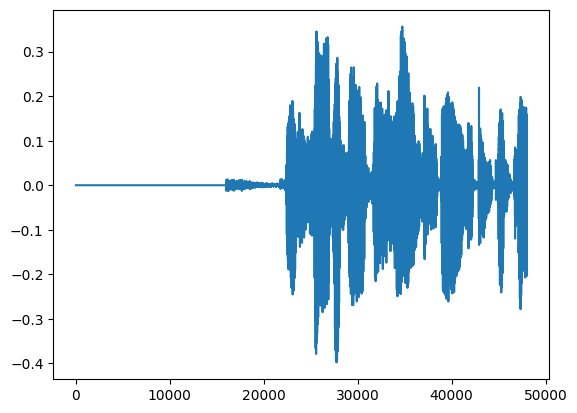

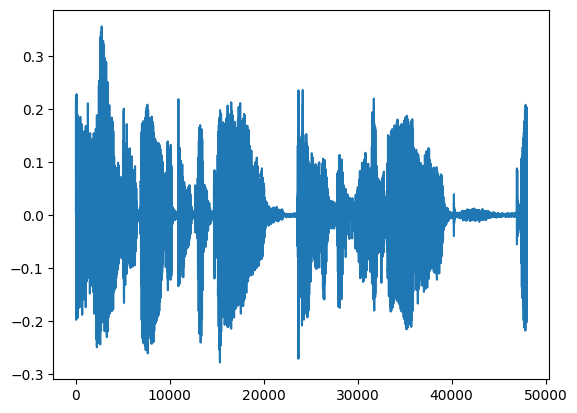

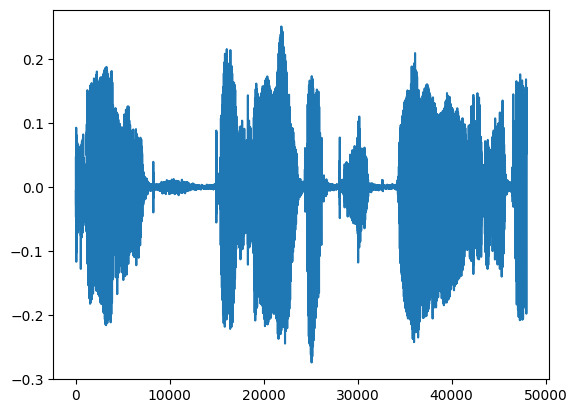

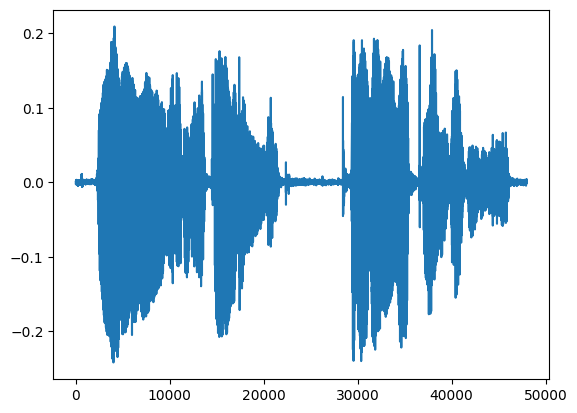

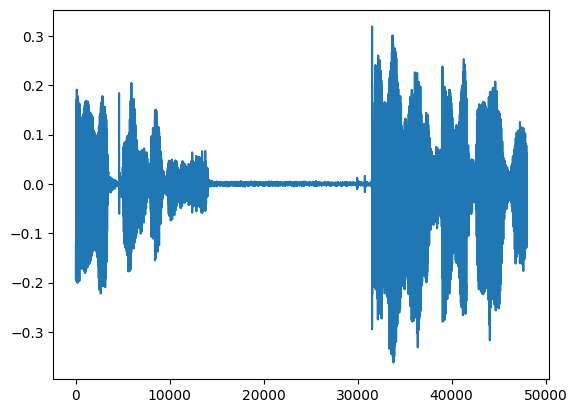

In [19]:
# chunk_len_in_secs: float = 8.0
# context_len_in_secs: float = 1.0
chunk_len_in_secs: float = 2.0
context_len_in_secs: float = 0.5

# max_steps_per_timestep: int = 5
max_steps_per_timestep: int = 4
stateful_decoding: bool = False


##########################################################################
buffer_len_in_secs = chunk_len_in_secs + 2* context_len_in_secs

n_buffers = 5

buffer_len = int(sample_rate*buffer_len_in_secs)
sampbuffer = np.zeros([buffer_len], dtype=np.float32)

chunk_reader = AudioChunkIterator(samples, chunk_len_in_secs, sample_rate)
chunk_len = int(sample_rate*chunk_len_in_secs)
count = 0
buffer_list = []
for chunk in chunk_reader:
    count +=1
    sampbuffer[:-chunk_len] = sampbuffer[chunk_len:]
    sampbuffer[-chunk_len:] = chunk
    buffer_list.append(np.array(sampbuffer))

    plt.plot(buffer_list[-1])
    plt.show()

    display(Audio(sampbuffer, rate=16000))
    if count >= n_buffers:
        break


## Change Decoding Strategy for Transducer Model

Below, we will change the decoding strategy for transducer models to preserve the alignments during autoregressive predictions. This will enable us to easily compute the "middle token" during decoding.

In [21]:
# Change Decoding Config
from omegaconf import OmegaConf, open_dict

# decoding_cfg = model.cfg.decoding
# with open_dict(decoding_cfg):
#     if stateful_decoding:  # Very slow procedure, avoid unless really needed
#         decoding_cfg.strategy = "greedy"
#     else:
#         decoding_cfg.strategy = "greedy_batch"

#     decoding_cfg.preserve_alignments = True  # required to compute the middle token for transducers.
#     decoding_cfg.fused_batch_size = -1  # temporarily stop fused batch during inference.

# model.change_decoding_strategy(decoding_cfg)

# # Change Decoding Config
# from omegaconf import OmegaConf, open_dict

# decoding_cfg = model.cfg.decoding
# with open_dict(decoding_cfg):
#     if stateful_decoding:  # Very slow procedure, avoid unless really needed
#         decoding_cfg.strategy = "greedy"
#     else:
#         decoding_cfg.strategy = "greedy_batch"

#     decoding_cfg.preserve_alignments = True  # required to compute the middle token for transducers.
#     decoding_cfg.fused_batch_size = -1  # temporarily stop fused batch during inference.

#     # Disable CUDA graphs for fine-tuned models
#     if hasattr(decoding_cfg, 'loop_labels_computer_config'):
#         decoding_cfg.loop_labels_computer_config.use_cuda_graph_decoder = False
#     else:
#         # Fallback: create the config if it doesn't exist
#         decoding_cfg.loop_labels_computer_config = OmegaConf.create({
#             'use_cuda_graph_decoder': False
#         })

# model.change_decoding_strategy(decoding_cfg)

decoding_cfg = model.cfg.decoding
with open_dict(decoding_cfg):
    decoding_cfg.strategy = "greedy"
    decoding_cfg.preserve_alignments = True
    decoding_cfg.fused_batch_size = -1

model.change_decoding_strategy(decoding_cfg)

print("Model loaded with CUDA graphs disabled via environment variable")

[NeMo I 2025-12-09 16:34:20 nemo_logging:381] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'clamp': -1.0, 'fastemit_lambda': 0.0}
[NeMo I 2025-12-09 16:34:20 nemo_logging:381] Joint fused batch size <= 0; Will temporarily disable fused batch step in the Joint.
[NeMo I 2025-12-09 16:34:20 nemo_logging:381] Changed decoding strategy to 
    model_type: rnnt
    strategy: greedy
    compute_hypothesis_token_set: false
    preserve_alignments: true
    confidence_cfg:
      preserve_frame_confidence: false
      preserve_token_confidence: false
      preserve_word_confidence: false
      exclude_blank: true
      aggregation: min
      tdt_include_duration: false
      method_cfg:
        name: entropy
        entropy_type: tsallis
        alpha: 0.33
        entropy_norm: exp
        temperature: DEPRECATED
    fused_batch_size: -1
    compute_timestamps: null
    compute_langs: false
    word_seperator: ' '
    rnnt_timestamp_type: all
    greedy:
      max_symbols_p

In [21]:
stride = 4 # 8 for ContextNet
asr_decoder = BatchedFrameASRRNNT(model, frame_len=chunk_len_in_secs, total_buffer=buffer_len_in_secs,
                                  batch_size=1,
                                  max_steps_per_timestep=max_steps_per_timestep,
                                  stateful_decoding=stateful_decoding)

samples = get_samples(concat_audio_path)

NameError: name 'BatchedFrameASRRNNT' is not defined

In [33]:
import tqdm
import math

def transcribe_buffers(asr_decoder, samples, num_frames, chunk_len_in_secs, buffer_len_in_secs, model_stride, plot=False):

  model.freeze()
  model_stride_in_secs = asr_decoder.asr_model.cfg.preprocessor.window_stride * model_stride
  print(model_stride_in_secs)
  tokens_per_chunk = math.ceil(chunk_len_in_secs / model_stride_in_secs)
  mid_delay = math.ceil((chunk_len_in_secs + (buffer_len_in_secs - chunk_len_in_secs) / 2) / model_stride_in_secs)
  print(mid_delay)
  batch_size = asr_decoder.batch_size  # Since only one sample buffers are available, batch size = 1

  assert batch_size == 1

  with torch.inference_mode():
    with torch.cuda.amp.autocast():
      asr_decoder.reset()
      asr_decoder.sample_offset = 0

      frame_reader = streaming_utils.AudioFeatureIterator(samples.copy(), asr_decoder.frame_len, asr_decoder.raw_preprocessor, asr_decoder.asr_model.device)
      asr_decoder.set_frame_reader(frame_reader, idx=0, limit_frames=num_frames if num_frames is not None else None)

      transcription = asr_decoder.transcribe(tokens_per_chunk, mid_delay, plot=plot)

  return transcription

In [34]:
transcription = transcribe_buffers(asr_decoder, samples, n_buffers, chunk_len_in_secs, buffer_len_in_secs, stride, plot=True)[0]

[NeMo W 2025-11-28 12:13:04 nemo_logging:393] /tmp/ipython-input-1698059622.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
      with torch.cuda.amp.autocast():
    


0.04
63

=== RAW BUFFER TRANSCRIPTIONS ===
Buffer 0: 'master and man dismounted.'
Buffer 1: 'and man dismounted from their beasts, and as soon as they.'
Buffer 2: 'and as soon as they had settled themselves at the foot of the tree.'
Buffer 3: 'was at the foot of the trees, sancho, who had?'
Buffer 4: 'who had had a good noontime meal that day.'

=== OVERLAP REMOVAL DEBUG ===
Starting with: 'master and man dismounted.'

Buffer 1: 'and man dismounted from their beasts, and as soon as they.'
Looking for overlap with: 'master and man dismounted.'
Found overlap of 3 words: ['and', 'man', 'dismounted.'] == ['and', 'man', 'dismounted']
Added: 'from their beasts, and as soon as they.'

Buffer 2: 'and as soon as they had settled themselves at the foot of the tree.'
Looking for overlap with: 'from their beasts, and as soon as they.'
Found overlap of 5 words: ['and', 'as', 'soon', 'as', 'they.'] == ['and', 'as', 'soon', 'as', 'they']
Added: 'had settled themselves at the foot of the tree.'

Buffe

In [35]:
print()
print("Transcription :")
print(transcription)


Transcription :
master and man dismounted. from their beasts, and as soon as they. had settled themselves at the foot of the tree. was at the foot of the trees, sancho, who had? had a good noontime meal that day.


# Transcribe the entire concatenated audio

Finally, we will decode the entire 15-minute audio clip with the settings chosen above. It should take just a few seconds to transcribe the entire clip with large chunk sizes, but it increases significantly for shorter chunk sizes.

In [36]:
# WER calculation
from nemo.collections.asr.metrics.wer import word_error_rate
# Collect all buffers from the audio file
sampbuffer = np.zeros([buffer_len], dtype=np.float32)

chunk_reader = AudioChunkIterator(samples, chunk_len_in_secs, sample_rate)
buffer_list = []
for chunk in chunk_reader:
    sampbuffer[:-chunk_len] = sampbuffer[chunk_len:]
    sampbuffer[-chunk_len:] = chunk
    buffer_list.append(np.array(sampbuffer))

asr_decoder = BatchedFrameASRRNNT(model, frame_len=chunk_len_in_secs, total_buffer=buffer_len_in_secs,
                                  batch_size=1,
                                  max_steps_per_timestep=max_steps_per_timestep,
                                  stateful_decoding=stateful_decoding)

transcription = transcribe_buffers(asr_decoder, samples, None, chunk_len_in_secs, buffer_len_in_secs, stride, plot=False)[0]
wer = word_error_rate(hypotheses=[transcription], references=[ref_transcript], use_cer=False)

print(f"WER: {round(wer*100,2)}%")

[NeMo I 2025-11-28 12:13:31 nemo_logging:381] PADDING: 0


[NeMo W 2025-11-28 12:13:31 nemo_logging:393] /tmp/ipython-input-1698059622.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
      with torch.cuda.amp.autocast():
    


Performing Stateful decoding : False
0.04
63

=== OVERLAP REMOVAL DEBUG ===
Starting with: 'master and man dismounted.'

Buffer 1: 'and man dismounted from their beasts, and as soon as they.'
Looking for overlap with: 'master and man dismounted.'
Found overlap of 3 words: ['and', 'man', 'dismounted.'] == ['and', 'man', 'dismounted']
Added: 'from their beasts, and as soon as they.'

Buffer 2: 'and as soon as they had settled themselves at the foot of the tree.'
Looking for overlap with: 'from their beasts, and as soon as they.'
Found overlap of 5 words: ['and', 'as', 'soon', 'as', 'they.'] == ['and', 'as', 'soon', 'as', 'they']
Added: 'had settled themselves at the foot of the tree.'

Buffer 3: 'was at the foot of the trees, sancho, who had?'
Looking for overlap with: 'settled themselves at the foot of the tree.'
Added: 'was at the foot of the trees, sancho, who had?'

Buffer 4: 'who had had a good noontime meal that day.'
Looking for overlap with: 'the foot of the trees, sancho, who ha

In [37]:
print(ref_transcript, "\n", transcription)

 master and man dismounted from their beasts and as soon as they had settled themselves at the foot of the trees sancho who had had a good noontide meal that day let himself without more ado pass the gates of sleep but don quixote whom his thoughts far more than hunger kept awake could not close an eye and roamed in fancy to and fro through all sorts of places at one moment it seemed to him that he was in the cave of montesinos and saw dulcinea transformed into a country wench skipping and mounting upon her she ass again that the words of the sage merlin were sounding in his ears setting forth the conditions to be observed and the exertions to be made for the disenchantment of dulcinea who is touching me and untrussing me dulcinea is perishing thou art living on regardless i am dying of hope deferred therefore untruss thyself with a good will for mine it is here in this retired spot to give thee at least two thousand lashes seeing this sancho got up and grappling with his master he gri

In [39]:
# print(np.__version__)
# # Add this debug code before the problematic transcribe_buffers call:
# print("=== DEBUGGING MODEL OUTPUT ===")

# # Test simple transcription first (without buffering)
# simple_test = model.transcribe([concat_audio_path[:16000*5]])  # First 5 seconds
# print(f"Simple transcription test: {simple_test}")

# # If simple transcription works, the issue is in the buffered inference logic

In [21]:
# Instead of 5 seconds (which might still be too much on CPU):
print("=== DEBUGGING MODEL OUTPUT (CPU) ===")

# Test with just 1 second of audio
import librosa
small_audio = librosa.load(concat_audio_path, sr=16000, duration=1.0)[0]  # Just 1 second
print(f"Small audio shape: {small_audio.shape}")

# Save to temp file and transcribe
import tempfile
import soundfile as sf

with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_file:
    sf.write(temp_file.name, small_audio, 16000)
    simple_test = model.transcribe([temp_file.name])
    print(f"Simple transcription test (1s): {simple_test}")

=== DEBUGGING MODEL OUTPUT (CPU) ===
Small audio shape: (16000,)


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s][NeMo W 2025-11-27 14:55:32 nemo_logging:393] /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
      warnings.warn(warn_msg)
    
[NeMo W 2025-11-27 14:55:34 nemo_logging:393] Function ``_transcribe_output_processing`` is deprecated. The return type of args will be updated in the upcoming release to ensure a consistent output format across all decoder types, such that a "Hypothesis" object is always returned.
Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

Simple transcription test (1s): (['they said about.'], ['they said about.'])


# Find the differences in the transcript

Word Error Rate is a great tool to measure the performance of the model, but we can go further and debug exactly where mistakes were made. This will further help us determine if the transcript was incorrect due to the merge algorithm rather than the model making any mistake during transcription.

In [40]:
#@title Run to setup Text Diff
import difflib
from typing import List, Any, Callable, Tuple, Union
from itertools import zip_longest
import html
import re

Token = str
TokenList = List[Token]

whitespace = re.compile('\s+')
end_sentence = re.compile('[.]\s+')

def tokenize(s:str) -> TokenList:
    '''Split a string into tokens'''
    return whitespace.split(s)

def untokenize(ts:TokenList) -> str:
    '''Join a list of tokens into a string'''
    return ' '.join(ts)

def sentencize(s:str) -> TokenList:
    '''Split a string into a list of sentences'''
    return end_sentence.split(s)

def unsentencise(ts:TokenList) -> str:
    '''Join a list of sentences into a string'''
    return '. '.join(ts)

def html_unsentencise(ts:TokenList) -> str:
    '''Joing a list of sentences into HTML for display'''
    return ''.join(f'<p>{t}</p>' for t in ts)

def mark_text(text:str) -> str:
    return f'<span style="color: red;">{text}</span>'

def mark_span(text:TokenList) -> TokenList:
    if len(text) > 0:
        text[0] = '<span style="background: #69E2FB;">' + text[0]
        text[-1] += '</span>'
    return text

def markup_diff(a:TokenList, b:TokenList,
                mark=mark_span,
                default_mark = lambda x: x,
                isjunk=None) -> Tuple[TokenList, TokenList]:
    """Returns a and b with any differences processed by mark

    Junk is ignored by the differ
    """
    seqmatcher = difflib.SequenceMatcher(isjunk=isjunk, a=a, b=b, autojunk=False)
    out_a, out_b = [], []
    for tag, a0, a1, b0, b1 in seqmatcher.get_opcodes():
        markup = default_mark if tag == 'equal' else mark
        out_a += markup(a[a0:a1])
        out_b += markup(b[b0:b1])
    assert len(out_a) == len(a)
    assert len(out_b) == len(b)
    return out_a, out_b


def align_seqs(a: TokenList, b: TokenList, fill:Token='') -> Tuple[TokenList, TokenList]:
    out_a, out_b = [], []
    seqmatcher = difflib.SequenceMatcher(a=a, b=b, autojunk=False)
    for tag, a0, a1, b0, b1 in seqmatcher.get_opcodes():
        delta = (a1 - a0) - (b1 - b0)
        out_a += a[a0:a1] + [fill] * max(-delta, 0)
        out_b += b[b0:b1] + [fill] * max(delta, 0)
    assert len(out_a) == len(out_b)
    return out_a, out_b


def html_sidebyside(a, b):
    # Set the panel display
    out = '<div style="display: grid;grid-template-columns: 1fr 1fr;grid-gap: 20px;">'
    # There's some CSS in Jupyter notebooks that makes the first pair unalign. This is a workaround
    out += '<p></p><p></p>'
    for left, right in zip_longest(a, b, fillvalue=''):
        out += f'<p>{left}</p>'
        out += f'<p>{right}</p>'
        out += '</div>'
    return out

def html_diffs(a, b):
    a = html.escape(a)
    b = html.escape(b)

    out_a, out_b = [], []
    for sent_a, sent_b in zip(*align_seqs(sentencize(a), sentencize(b))):
        mark_a, mark_b = markup_diff(tokenize(sent_a), tokenize(sent_b))
        out_a.append(untokenize(mark_a))
        out_b.append(untokenize(mark_b))

    return html_sidebyside(out_a, out_b)

[NeMo W 2025-11-28 12:22:55 nemo_logging:393] <>:11: SyntaxWarning: invalid escape sequence '\s'
    
[NeMo W 2025-11-28 12:22:55 nemo_logging:393] <>:12: SyntaxWarning: invalid escape sequence '\s'
    
[NeMo W 2025-11-28 12:22:55 nemo_logging:393] <>:11: SyntaxWarning: invalid escape sequence '\s'
    
[NeMo W 2025-11-28 12:22:55 nemo_logging:393] <>:12: SyntaxWarning: invalid escape sequence '\s'
    
[NeMo W 2025-11-28 12:22:55 nemo_logging:393] /tmp/ipython-input-1907497300.py:11: SyntaxWarning: invalid escape sequence '\s'
      whitespace = re.compile('\s+')
    
[NeMo W 2025-11-28 12:22:55 nemo_logging:393] /tmp/ipython-input-1907497300.py:12: SyntaxWarning: invalid escape sequence '\s'
      end_sentence = re.compile('[.]\s+')
    


In [41]:
from IPython.display import HTML

def show_diffs(a, b):
    display(HTML(html_diffs(a,b)))

In [30]:
show_diffs(ref_transcript,  transcription)

# Extra: Middle token alignment in Transducers

The middle token algorithm is a general algorithm that works even for non-causal offline models relatively well. On the other hand, it requires larger chunk sizes and larger buffer sizes (which causes some latency).

For CTC, it is straightforward to decode the text from the log probabilities - take argmax. However, transducers have a much more complicated decoding technique, and taking middle token alignment is not so straightforward.

So below, we will take a deep dive into what transducer alignments are and how we can use them to perform middle token selection.



```python
def transcribe(self, tokens_per_chunk: int, delay: int, plot=False):
    ...
        all_toks = []
        for a_idx, alignment in enumerate(alignments):
            alignment = alignment[len(alignment) - 1 - delay : len(alignment) - 1 - delay + tokens_per_chunk]
            ids, toks = self._alignment_decoder(alignment, self.asr_model.tokenizer, self.blank_id)
            all_toks.append(toks)
    ...


```

In [ ]:
from nemo.collections.asr.parts.utils.manifest_utils import read_manifest

manifest_data = read_manifest(manifest)
print(f"Read {len(manifest_data)} samples from manifest {manifest}")

In [ ]:
sample_idx = 0
audio_filepath = manifest_data[sample_idx]['audio_filepath']
text = manifest_data[sample_idx]['text']

print("Audio filepath   :", audio_filepath)
print("Ground truth text:", text)
print("Duration         :", manifest_data[sample_idx]["duration"])

------

To track the alignment array, we need to let the Transducer Decoding strategy know to preserve the alignments. Since it is done during greedy / beam decoding, it can be simply done by setting a flag and updating the decoding strategy.

In [ ]:
decoding_cfg = model.cfg.decoding

with open_dict(decoding_cfg):
  decoding_cfg.preserve_alignments = True  # required to compute the middle token for transducers.
  decoding_cfg.fused_batch_size = -1  # temporarily stop fused batch during inference.

model.change_decoding_strategy(decoding_cfg)

In [ ]:
greedy_hypotheses, beam_hypotheses = model.transcribe([audio_filepath], return_hypotheses=True)

In [ ]:
hyp = greedy_hypotheses[0]  # only one sample in batch
print("Hypothesis text  :", hyp.text)
print("Ground truth text:", text)

wer = word_error_rate(hypotheses=[hyp.text], references=[text], use_cer=False)
print("Word error rate of audio :", wer)

# Print alignments


In [ ]:
alignments = hyp.alignments

Let's calculate the alignment grid. We will de-tokenize the sub-word token if it is a valid index in the vocabulary and use '' as a placeholder for the Transducer Blank token.

Note that each timestep here is (roughly) 40 milli-seconds timestamp (since the window stride is 10 ms, and Conformer has 4x stride). The resolution of the model differs based on the stride of the model - QuartzNet has 2x stride (20 ms), Conformer has 4x stride (40 ms), and ContextNet has 8x stride (80 ms).

Note: You can modify the value of config.model.loss.warprnnt_numba_kwargs.fastemit_lambda before training and see an impact on final alignment latency! For a tutorial to train your Transducer models, refer to [ASR with Transducers in NeMo](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/asr/ASR_with_Transducers.ipynb).

------

First, let's listen to the audio clip itself. We can then determine if the text transcription is being accurately transcribed.

In [ ]:
display(Audio(filename=audio_filepath, rate=model.cfg.sample_rate))

In [ ]:
model_stride = 4  # 4 for Conformers; 8 for ContextNet / Citrinet;
window_stride = model.cfg.preprocessor.window_stride

time_ms = 0.0  # time in ms

# Compute the alignment grid
for ti in range(len(alignments)):
  t_u = []
  for uj in range(len(alignments[ti])):
    logprobs, token = alignments[ti][uj]
    token = token.to('cpu').numpy().tolist()
    decoded_token = model.decoding.decode_ids_to_tokens([token])[0] if token != model.decoding.blank_id else ''  # token at index len(vocab) == RNNT blank token
    t_u.append(decoded_token)

  time_ms += model_stride * window_stride
  print(f"Tokens at timestep {ti} (time={time_ms:0.2f} s) = {t_u}")


-------

You can see that there were roughly as many timesteps as the original duration of the audio. Since the transducer alignment is characterized as a Ti x Uj dangling array, we can treat Ti as the equivalent to the timestep of the acoustic signal itself. Therefore, if we take "middle" slices over the Ti dimension during decoding, we can effectively compute the middle token alignment even for transducer models!

# Final Notes

Now, anyone can perform long audio transcription using any NeMo transducer model. You could even try to modify the chunk and buffer sizes to try to stream these models.

For further references on training your own transducer models, please refer to [ASR with Transducers](https://github.com/NVIDIA/NeMo/blob/stable/tutorials/asr/ASR_with_Transducers.ipynb) tutorial.

# Single Chunk Streaming wo Buffering

In [33]:
# Simple 2-Second Chunk Transcription (No Buffering)

import numpy as np
import torch
import soundfile as sf
import tempfile
import os
from tqdm import tqdm

class SimpleChunkTranscriber:
    """
    Simple audio chunking and transcription without complex buffering
    """

    def __init__(self, model, chunk_size_sec=2.0, overlap_sec=0.3):
        self.model = model
        self.chunk_size_sec = chunk_size_sec
        self.overlap_sec = overlap_sec
        self.sample_rate = 16000

        print(f"Simple Transcriber Setup:")
        print(f"  Chunk size: {chunk_size_sec}s")
        print(f"  Overlap: {overlap_sec}s")
        print(f"  Effective latency: {chunk_size_sec}s per chunk")

    def transcribe_long_audio(self, audio_path_or_samples, plot=False):
        """
        Transcribe long audio by breaking into chunks

        Args:
            audio_path_or_samples: Either file path or numpy array of samples
            plot: Whether to print debug information
        """

        # Load audio if path provided, otherwise use samples directly
        if isinstance(audio_path_or_samples, str):
            samples = get_samples(audio_path_or_samples)
        else:
            samples = audio_path_or_samples

        print(f"Total audio duration: {len(samples) / self.sample_rate:.1f} seconds")

        # Calculate chunk parameters
        chunk_samples = int(self.chunk_size_sec * self.sample_rate)
        overlap_samples = int(self.overlap_sec * self.sample_rate)
        step_samples = chunk_samples - overlap_samples

        chunk_results = []

        # Process each chunk
        for start in range(0, len(samples), step_samples):
            end = min(start + chunk_samples, len(samples))

            if end - start < self.sample_rate * 0.5:  # Skip very short chunks (<0.5s)
                break

            chunk = samples[start:end]

            # Transcribe this chunk
            chunk_text = self._transcribe_chunk(chunk, start / self.sample_rate, end / self.sample_rate, plot)

            if chunk_text.strip():  # Only add non-empty transcriptions
                chunk_results.append({
                    'text': chunk_text.strip(),
                    'start_time': start / self.sample_rate,
                    'end_time': end / self.sample_rate,
                    'chunk_idx': len(chunk_results)
                })

        # Stitch chunks together
        final_text = self._stitch_chunks(chunk_results, plot)

        return final_text, chunk_results

    def _transcribe_chunk(self, chunk_samples, start_time, end_time, plot=False):
        """Transcribe a single chunk"""
        try:
            # Create temporary audio file
            with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_file:
                sf.write(temp_file.name, chunk_samples, self.sample_rate)

                # Transcribe using your working model.transcribe method
                result = self.model.transcribe([temp_file.name])

                if result and result[0]:
                    # print(result)
                    text = result[0][0].strip()
                    print(text)
                    if plot:
                        print(f"Chunk {start_time:.1f}s-{end_time:.1f}s: '{text}'")
                    return text
                else:
                    if plot:
                        print(f"Chunk {start_time:.1f}s-{end_time:.1f}s: [EMPTY]")
                    return ""

        except Exception as e:
            print(f"Error transcribing chunk {start_time:.1f}s-{end_time:.1f}s: {e}")
            return ""
        finally:
            # Clean up temp file
            try:
                os.unlink(temp_file.name)
            except:
                pass

    def _stitch_chunks(self, chunk_results, plot=False):
        """Stitch chunk transcriptions together with overlap removal"""

        if not chunk_results:
            return ""

        if len(chunk_results) == 1:
            return chunk_results[0]['text']

        if plot:
            print(f"\n=== STITCHING {len(chunk_results)} CHUNKS ===")

        # Start with first chunk
        result_words = chunk_results[0]['text'].split()

        for i in range(1, len(chunk_results)):
            current_words = chunk_results[i]['text'].split()

            if not current_words:
                continue

            # Find overlap between end of result and beginning of current chunk
            best_overlap = self._find_word_overlap(result_words, current_words, max_overlap=1)

            # Add non-overlapping portion
            new_words = current_words[best_overlap:]
            result_words.extend(new_words)

            if plot:
                print(f"Chunk {i}: Removed {best_overlap} overlapping words, added {len(new_words)} new words")
                print(f"  Overlap: {current_words[:best_overlap]}")
                print(f"  Added: {new_words}")

        return " ".join(result_words)

    def _find_word_overlap(self, words1, words2, max_overlap=8):
        """Find how many words at the start of words2 overlap with the end of words1"""

        best_overlap = 0

        # Try different overlap lengths
        for overlap_len in range(min(max_overlap, len(words1), len(words2)), 0, -1):
            # Check if last N words of words1 match first N words of words2
            if words1[-overlap_len:] == words2[:overlap_len]:
                best_overlap = overlap_len
                break

        return best_overlap

# Usage Example
def transcribe_with_simple_chunks(model, audio_path, chunk_size=2.0, overlap=0.3):
    """
    Main function to transcribe long audio with simple chunking
    """

    transcriber = SimpleChunkTranscriber(model, chunk_size_sec=chunk_size, overlap_sec=overlap)

    # Transcribe
    final_text, chunk_details = transcriber.transcribe_long_audio(audio_path, plot=True)

    print(f"\n=== FINAL RESULT ===")
    print(f"Transcription: '{final_text}'")
    print(f"Processed {len(chunk_details)} chunks")
    print(f"Total duration: {chunk_details[-1]['end_time']:.1f}s" if chunk_details else "0s")

    return final_text

# Run it!
final_transcription = transcribe_with_simple_chunks(
    model,
    concat_audio_path,
    chunk_size=2.0,    # 2-second chunks
    overlap=0.3        # 0.3-second overlap for context
)


Simple Transcriber Setup:
  Chunk size: 2.0s
  Overlap: 0.3s
  Effective latency: 2.0s per chunk
Total audio duration: 906.4 seconds


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


he lives thy loss, he.
Chunk 0.0s-2.0s: 'he lives thy loss, he.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


he dies from every limb.
Chunk 1.7s-3.7s: 'he dies from every limb.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


them mangled by the lightnings of.
Chunk 3.4s-5.4s: 'them mangled by the lightnings of.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


lightnings of godhead shine from which.
Chunk 5.1s-7.1s: 'lightnings of godhead shine from which.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


from which thy darkness has not where to.
Chunk 6.8s-8.8s: 'from which thy darkness has not where to.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


where to hide queen?
Chunk 8.5s-10.5s: 'where to hide queen?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


క్వించి ఎంపారా టు పీర్టీ
Chunk 10.2s-12.2s: 'క్వించి ఎంపారా టు పీర్టీ'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


in flesh was raymond.
Chunk 11.9s-13.9s: 'in flesh was raymond.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


raymont.
Chunk 13.6s-15.6s: 'raymont.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


how he was killed and buried from the.
Chunk 15.3s-17.3s: 'how he was killed and buried from the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


from the dead, how he arose to life with.
Chunk 17.0s-19.0s: 'from the dead, how he arose to life with.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


life with victory and rained.
Chunk 18.7s-20.7s: 'life with victory and rained.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


reigned in heaven, how all of us.
Chunk 20.4s-22.4s: 'reigned in heaven, how all of us.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


of us shall be glorious like him whose.
Chunk 22.1s-24.1s: 'of us shall be glorious like him whose.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


whose hearts to his are wed.
Chunk 23.8s-25.8s: 'whose hearts to his are wed.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


how they who die for love of reason.
Chunk 25.5s-27.5s: 'how they who die for love of reason.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


reason give hypocrites t.
Chunk 27.2s-29.2s: 'reason give hypocrites t.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


tyrants, sophists.
Chunk 28.9s-30.9s: 'tyrants, sophists.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


all who sell their neighbors ill.
Chunk 30.6s-32.6s: 'all who sell their neighbors ill.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


ill for holy to hell.
Chunk 32.3s-34.3s: 'ill for holy to hell.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


how the.
Chunk 34.0s-36.0s: 'how the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


all the dead sink condemns the bad who live.
Chunk 35.7s-37.7s: 'all the dead sink condemns the bad who live.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


who live, how all he does?
Chunk 37.4s-39.4s: 'who live, how all he does?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


does becomes a law for men.
Chunk 39.1s-41.1s: 'does becomes a law for men.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


how he at last to judge.
Chunk 40.8s-42.8s: 'how he at last to judge.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


shall come again the.
Chunk 42.5s-44.5s: 'shall come again the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


this world's thick vapors whelm.
Chunk 44.2s-46.2s: 'this world's thick vapors whelm.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


elm your eyes unworthy of that glory.
Chunk 45.9s-47.9s: 'elm your eyes unworthy of that glory.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


a glorious show blind his.
Chunk 47.6s-49.6s: 'a glorious show blind his.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


his spendor bent upon his shame.
Chunk 49.3s-51.3s: 'his spendor bent upon his shame.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


is shame money is false.
Chunk 51.0s-53.0s: 'is shame money is false.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


false and light, unless it be.
Chunk 52.7s-54.7s: 'false and light, unless it be.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


be bought by a man's own worthy quality.
Chunk 54.4s-56.4s: 'be bought by a man's own worthy quality.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


qualities and blood is such.
Chunk 56.1s-58.1s: 'qualities and blood is such.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


such that it's corrupt disease and.
Chunk 57.8s-59.8s: 'such that it's corrupt disease and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


an ignorate pretense are foul to see.
Chunk 59.5s-61.5s: 'an ignorate pretense are foul to see.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


సీపాలో
Chunk 61.2s-63.2s: 'సీపాలో'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


బెస్ట్యా
Chunk 62.9s-64.9s: 'బెస్ట్యా'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


the people is a beast of muddy brain.
Chunk 64.6s-66.6s: 'the people is a beast of muddy brain.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


brain that knows not its own force.
Chunk 66.3s-68.3s: 'brain that knows not its own force.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


force, and therefore stands loaded.
Chunk 68.0s-70.0s: 'force, and therefore stands loaded.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


loaded with wood and stone, the power.
Chunk 69.7s-71.7s: 'loaded with wood and stone, the power.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


the powerless hands of a mere child.
Chunk 71.4s-73.4s: 'the powerless hands of a mere child.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


child guide it with bit and rain.
Chunk 73.1s-75.1s: 'child guide it with bit and rain.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


one kick would be enough to.
Chunk 74.8s-76.8s: 'one kick would be enough to.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


enough to break the chain, but the beast.
Chunk 76.5s-78.5s: 'enough to break the chain, but the beast.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


the beast fears and what the child.
Chunk 78.2s-80.2s: 'the beast fears and what the child.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


child demands it does.
Chunk 79.9s-81.9s: 'child demands it does.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


does, nor its own terror under.
Chunk 81.6s-83.6s: 'does, nor its own terror under.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


or understands confused and stupef.
Chunk 83.3s-85.3s: 'or understands confused and stupef.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


stupefied by bugbear's vein.
Chunk 85.0s-87.0s: 'stupefied by bugbear's vein.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


and most wonderful.
Chunk 86.7s-88.7s: 'and most wonderful.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


wonderful that penance haath new.
Chunk 88.4s-90.4s: 'wonderful that penance haath new.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


hth no blame which magdalen.
Chunk 90.1s-92.1s: 'hth no blame which magdalen.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


land found sweet purging.
Chunk 91.8s-93.8s: 'land found sweet purging.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


urging our shame self p.
Chunk 93.5s-95.5s: 'urging our shame self p.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


self punishment is virtue, all men know.
Chunk 95.2s-97.2s: 'self punishment is virtue, all men know.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


o organ of rut, not.
Chunk 96.9s-98.9s: 'o organ of rut, not.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


to not reason is the lord who.
Chunk 98.6s-100.6s: 'to not reason is the lord who.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


who from the body politic doth?
Chunk 100.3s-102.3s: 'who from the body politic doth?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


doth drain lost for himself.
Chunk 102.0s-104.0s: 'doth drain lost for himself.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


self instead of toil and pain.
Chunk 103.7s-105.7s: 'self instead of toil and pain.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


mean leaving us lean as.
Chunk 105.4s-107.4s: 'mean leaving us lean as.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


lean as crickets on dry sward.
Chunk 107.1s-109.1s: 'lean as crickets on dry sward.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


well, too, if he.
Chunk 108.8s-110.8s: 'well, too, if he.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


key, like love, would filch our hor.
Chunk 110.5s-112.5s: 'key, like love, would filch our hor.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


our hoard with pleasure to ourselves.
Chunk 112.2s-114.2s: 'our hoard with pleasure to ourselves.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


selves sluicing our vein.
Chunk 113.9s-115.9s: 'selves sluicing our vein.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


vein and vigor to perpetuate the.
Chunk 115.6s-117.6s: 'vein and vigor to perpetuate the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


to the strain of a life by spill.
Chunk 117.3s-119.3s: 'to the strain of a life by spill.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


spilth of life within us stored.
Chunk 119.0s-121.0s: 'spilth of life within us stored.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


ward heaven help that body.
Chunk 120.7s-122.7s: 'ward heaven help that body.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


a body which a little mind housed.
Chunk 122.4s-124.4s: 'a body which a little mind housed.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


housed than a head, lacking ears, tongue and.
Chunk 124.1s-126.1s: 'housed than a head, lacking ears, tongue and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


tongue and eyes in senseless but.
Chunk 125.8s-127.8s: 'tongue and eyes in senseless but.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


this, but for smell can tyrannize.
Chunk 127.5s-129.5s: 'this, but for smell can tyrannize.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


organize due to.
Chunk 129.2s-131.2s: 'organize due to.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


do to thee their praise of maiden pure.
Chunk 130.9s-132.9s: 'do to thee their praise of maiden pure.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


pure of teaming motherhood.
Chunk 132.6s-134.6s: 'pure of teaming motherhood.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


vou, like arctorus.
Chunk 134.3s-136.3s: 'vou, like arctorus.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


steadfast in the skies.
Chunk 136.0s-138.0s: 'steadfast in the skies.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


with tardy sense guide us.
Chunk 137.7s-139.7s: 'with tardy sense guide us.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


lightest to thy kingdom fair.
Chunk 139.4s-141.4s: 'lightest to thy kingdom fair.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


bearing alone the load of liberty.
Chunk 141.1s-143.1s: 'bearing alone the load of liberty.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


the two stray kid.
Chunk 142.8s-144.8s: 'the two stray kid.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


the kittens gradually make themselves at home.
Chunk 144.5s-146.5s: 'the kittens gradually make themselves at home.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


home somehow or other.
Chunk 146.2s-148.2s: 'home somehow or other.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


their cat has taught them that he's in charge.
Chunk 147.9s-149.9s: 'their cat has taught them that he's in charge.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


in charge here, and he just chases.
Chunk 149.6s-151.6s: 'in charge here, and he just chases.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


uses them for fun now and again when he's not.
Chunk 151.3s-153.3s: 'uses them for fun now and again when he's not.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


when he's not busy sleeping.
Chunk 153.0s-155.0s: 'when he's not busy sleeping.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


she doesn't pick them up, but just.
Chunk 154.7s-156.7s: 'she doesn't pick them up, but just.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


just having them in the room sure doesn't give her.
Chunk 156.4s-158.4s: 'just having them in the room sure doesn't give her.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


of her asthma, when are you getting?
Chunk 158.1s-160.1s: 'of her asthma, when are you getting?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


getting rid of these cats, i'm not fix.
Chunk 159.8s-161.8s: 'getting rid of these cats, i'm not fix.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


fixing the start annex to kate's cat.
Chunk 161.5s-163.5s: 'fixing the start annex to kate's cat.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


cat home right away.
Chunk 163.2s-165.2s: 'cat home right away.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


way when i bring home menu program, he.
Chunk 164.9s-166.9s: 'way when i bring home menu program, he.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


he says, how come you're taking one less?
Chunk 166.6s-168.6s: 'he says, how come you're taking one less?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


unless course this half i.
Chunk 168.3s-170.3s: 'unless course this half i.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


i explained that i'm taking music and.
Chunk 170.0s-172.0s: 'i explained that i'm taking music and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


and also biology, algebra, english.
Chunk 171.7s-173.7s: 'and also biology, algebra, english.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


english and french music.
Chunk 173.4s-175.4s: 'english and french music.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


he snorts, pop.
Chunk 175.1s-177.1s: 'he snorts, pop.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


pop, it's a course he does.
Chunk 176.8s-178.8s: 'pop, it's a course he does.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


he does, and for once, i w.
Chunk 178.5s-180.5s: 'he does, and for once, i w.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


i win around, i keep.
Chunk 180.2s-182.2s: 'i win around, i keep.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


keep music for this semester.
Chunk 181.9s-183.9s: 'keep music for this semester.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


i'll be lucky if i have time to breat.
Chunk 183.6s-185.6s: 'i'll be lucky if i have time to breat.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


breathe sometimes schools do.
Chunk 185.3s-187.3s: 'breathe sometimes schools do.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


do let kids take a lot of soft.
Chunk 187.0s-189.0s: 'do let kids take a lot of soft.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


soft courses and then they're out on a.
Chunk 188.7s-190.7s: 'soft courses and then they're out on a.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


on a limb later.
Chunk 190.4s-192.4s: 'on a limb later.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


hu so he cared.
Chunk 192.1s-194.1s: 'hu so he cared.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


कैर्स हाँ
Chunk 193.8s-195.8s: 'कैर्स हाँ'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


besides, says tom.
Chunk 195.5s-197.5s: 'besides, says tom.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


top half the reason you and your.
Chunk 197.2s-199.2s: 'top half the reason you and your.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


and your father are always bickering is that you're so.
Chunk 198.9s-200.9s: 'and your father are always bickering is that you're so.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


are so much alike me.
Chunk 200.6s-202.6s: 'are so much alike me.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


like him.
Chunk 202.3s-204.3s: 'like him.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


sure, as long.
Chunk 204.0s-206.0s: 'sure, as long.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


as long as there's a bone on the floor, the two of.
Chunk 205.7s-207.7s: 'as long as there's a bone on the floor, the two of.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


two of you worry it, i get.
Chunk 207.4s-209.4s: 'two of you worry it, i get.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


i get the pillows comfortably arranged on the floor.
Chunk 209.1s-211.1s: 'i get the pillows comfortably arranged on the floor.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


on the floor, with a big bottle of soda and a bag.
Chunk 210.8s-212.8s: 'on the floor, with a big bottle of soda and a bag.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


and a bag of popcorn within easy reach.
Chunk 212.5s-214.5s: 'and a bag of popcorn within easy reach.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


pop goes right on tuning his.
Chunk 214.2s-216.2s: 'pop goes right on tuning his.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


tuning his channel you're getting all.
Chunk 215.9s-217.9s: 'tuning his channel you're getting all.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


being altogether too upset about these program.
Chunk 217.6s-219.6s: 'being altogether too upset about these program.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


programs stop it and behave yourself.
Chunk 219.3s-221.3s: 'programs stop it and behave yourself.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


self, it's your fault.
Chunk 221.0s-223.0s: 'self, it's your fault.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


fault, mop it up yourself.
Chunk 222.7s-224.7s: 'fault, mop it up yourself.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


i hear the t v going for a few minutes.
Chunk 224.4s-226.4s: 'i hear the t v going for a few minutes.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


few minutes, then pop turns it off.
Chunk 226.1s-228.1s: 'few minutes, then pop turns it off.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


it off and goes in the kitchen to talk to mom.
Chunk 227.8s-229.8s: 'it off and goes in the kitchen to talk to mom.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


mom well, i don't.
Chunk 229.5s-231.5s: 'mom well, i don't.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


i don't think you should turn a guy's t v program.
Chunk 231.2s-233.2s: 'i don't think you should turn a guy's t v program.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


program off in the middle without even finding out.
Chunk 232.9s-234.9s: 'program off in the middle without even finding out.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


me out about it look at my w.
Chunk 234.6s-236.6s: 'me out about it look at my w.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


my watch, it's a quarter to eleven.
Chunk 236.3s-238.3s: 'my watch, it's a quarter to eleven.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


oven, i turn off the television set.
Chunk 238.0s-240.0s: 'oven, i turn off the television set.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


that i've lost track of what's happening.
Chunk 239.7s-241.7s: 'that i've lost track of what's happening.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


happening, and it doesn't seem to be the grandfather.
Chunk 241.4s-243.4s: 'happening, and it doesn't seem to be the grandfather.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


father, who's a spook after all.
Chunk 243.1s-245.1s: 'father, who's a spook after all.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


it's the first time hilda has been to our house.
Chunk 244.8s-246.8s: 'it's the first time hilda has been to our house.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


house and tom introduces her around.
Chunk 246.5s-248.5s: 'house and tom introduces her around.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


around, i told tom.
Chunk 248.2s-250.2s: 'around, i told tom.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


tom, we shouldn't come so late, says hilda.
Chunk 249.9s-251.9s: 'tom, we shouldn't come so late, says hilda.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


tom says, thanks and looks.
Chunk 251.6s-253.6s: 'tom says, thanks and looks.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


and looks at hilda, and she blushes.
Chunk 253.3s-255.3s: 'and looks at hilda, and she blushes.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


really, tom drinks of the.
Chunk 255.0s-257.0s: 'really, tom drinks of the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


drinks a little more coffee and then he goes on.
Chunk 256.7s-258.7s: 'drinks a little more coffee and then he goes on.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


the trouble is i can't.
Chunk 258.4s-260.4s: 'the trouble is i can't.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


i can't get married on this flower shop job.
Chunk 260.1s-262.1s: 'i can't get married on this flower shop job.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


you know, i get drafted in a year.
Chunk 261.8s-263.8s: 'you know, i get drafted in a year.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


in a year or two anyway.
Chunk 263.5s-265.5s: 'in a year or two anyway.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


i've decided to enlist in the army.
Chunk 265.2s-267.2s: 'i've decided to enlist in the army.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


me, i'll have to check.
Chunk 266.9s-268.9s: 'me, i'll have to check.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


check some more, says tom.
Chunk 268.6s-270.6s: 'check some more, says tom.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


here's to you a long, happy.
Chunk 270.3s-272.3s: 'here's to you a long, happy.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


happy life, folks.
Chunk 272.0s-274.0s: 'happy life, folks.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


foks brought up a sack of potatoes.
Chunk 273.7s-275.7s: 'foks brought up a sack of potatoes.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


and a piece of cured.
Chunk 275.4s-277.4s: 'and a piece of cured.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


bird pork from the cellar.
Chunk 277.1s-279.1s: 'bird pork from the cellar.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


and grandmother packed some.
Chunk 278.8s-280.8s: 'and grandmother packed some.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


some loaves of saturday's bread.
Chunk 280.5s-282.5s: 'some loaves of saturday's bread.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


a jar of butter.
Chunk 282.2s-284.2s: 'a jar of butter.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


and several pumpkin pies.
Chunk 283.9s-285.9s: 'and several pumpkin pies.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


in the straw of the wagon box.
Chunk 285.6s-287.6s: 'in the straw of the wagon box.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


occasionally.
Chunk 287.3s-289.3s: 'occasionally.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


generally, one of the horses would tear.
Chunk 289.0s-291.0s: 'generally, one of the horses would tear.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


would tear off with his teeth.
Chunk 290.7s-292.7s: 'would tear off with his teeth.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


keith a plant full of bl.
Chunk 292.4s-294.4s: 'keith a plant full of bl.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


full of blossoms and walk.
Chunk 294.1s-296.1s: 'full of blossoms and walk.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


walk along munching it the flow.
Chunk 295.8s-297.8s: 'walk along munching it the flow.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


the flowers nodding in time to his.
Chunk 297.5s-299.5s: 'the flowers nodding in time to his.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


to his bites as he a down.
Chunk 299.2s-301.2s: 'to his bites as he a down.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


down toward them, it's.
Chunk 300.9s-302.9s: 'down toward them, it's.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


it's no better than a badger hole.
Chunk 302.6s-304.6s: 'it's no better than a badger hole.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


no proper dugout at all.
Chunk 304.3s-306.3s: 'no proper dugout at all.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


all now, why?
Chunk 306.0s-308.0s: 'all now, why?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


why is that auto?
Chunk 307.7s-309.7s: 'why is that auto?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


presently against one of.
Chunk 309.4s-311.4s: 'presently against one of.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


one of those banks i saw a.
Chunk 311.1s-313.1s: 'one of those banks i saw a.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


saw a sort of shed that.
Chunk 312.8s-314.8s: 'saw a sort of shed that.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


thatched with the same wine colored grass.
Chunk 314.5s-316.5s: 'thatched with the same wine colored grass.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


good grass that grew everywhere.
Chunk 316.2s-318.2s: 'good grass that grew everywhere.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


very glad, very glad.
Chunk 317.9s-319.9s: 'very glad, very glad.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


lad, she ejaculated.
Chunk 319.6s-321.6s: 'lad, she ejaculated.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


go get fixed up, comfort.
Chunk 321.3s-323.3s: 'go get fixed up, comfort.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


comfortable after a while, mrs sherida.
Chunk 323.0s-325.0s: 'comfortable after a while, mrs sherida.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


make good house.
Chunk 324.7s-326.7s: 'make good house.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


my grandmother.
Chunk 326.4s-328.4s: 'my grandmother.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


mother always spoke in a very loud tone.
Chunk 328.1s-330.1s: 'mother always spoke in a very loud tone.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


odd tone to foreigners as if.
Chunk 329.8s-331.8s: 'odd tone to foreigners as if.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


as if they were deaf, she.
Chunk 331.5s-333.5s: 'as if they were deaf, she.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


she made mrs shamer to understand the.
Chunk 333.2s-335.2s: 'she made mrs shamer to understand the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


and the friendly intention of our visit.
Chunk 334.9s-336.9s: 'and the friendly intention of our visit.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


and the bohemian woman.
Chunk 336.6s-338.6s: 'and the bohemian woman.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


woman handled the loaves of bread.
Chunk 338.3s-340.3s: 'woman handled the loaves of bread.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


and even smelled them.
Chunk 340.0s-342.0s: 'and even smelled them.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


and examined the pies with.
Chunk 341.7s-343.7s: 'and examined the pies with.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


it's with lively curiosity, explain.
Chunk 343.4s-345.4s: 'it's with lively curiosity, explain.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


exclaiming much good, much th.
Chunk 345.1s-347.1s: 'exclaiming much good, much th.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


think the family.
Chunk 346.8s-348.8s: 'think the family.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


family had been living on corn cakes and.
Chunk 348.5s-350.5s: 'family had been living on corn cakes and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


and sorgums for three days.
Chunk 350.2s-352.2s: 'and sorgums for three days.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


days i reme.
Chunk 351.9s-353.9s: 'days i reme.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


i remembered what the conductor had said about.
Chunk 353.6s-355.6s: 'i remembered what the conductor had said about.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


said about her eyes, her.
Chunk 355.3s-357.3s: 'said about her eyes, her.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


her skin was brown, too, and.
Chunk 357.0s-359.0s: 'her skin was brown, too, and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


and in her cheeks she had a glow of.
Chunk 358.7s-360.7s: 'and in her cheeks she had a glow of.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


of rich dark color.
Chunk 360.4s-362.4s: 'of rich dark color.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


even from a distance, one could see.
Chunk 362.1s-364.1s: 'even from a distance, one could see.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


see that there was something strange about the.
Chunk 363.8s-365.8s: 'see that there was something strange about the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


about this boy, he was.
Chunk 365.5s-367.5s: 'about this boy, he was.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


he was born like that, the others are smart.
Chunk 367.2s-369.2s: 'he was born like that, the others are smart.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


a smart ambroche, he made good.
Chunk 368.9s-370.9s: 'a smart ambroche, he made good.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


he made good farmer, he struck.
Chunk 370.6s-372.6s: 'he made good farmer, he struck.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


struck ambroch on the back and the.
Chunk 372.3s-374.3s: 'struck ambroch on the back and the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


and the boy smiled knowingly.
Chunk 374.0s-376.0s: 'and the boy smiled knowingly.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


at that moment, the father came.
Chunk 375.7s-377.7s: 'at that moment, the father came.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


there came out of the hole in the bank.
Chunk 377.4s-379.4s: 'there came out of the hole in the bank.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


it was so long that it bushed out.
Chunk 379.1s-381.1s: 'it was so long that it bushed out.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


out behind his ears and made him look like.
Chunk 380.8s-382.8s: 'out behind his ears and made him look like.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


look like the old portraits i remember in virgi.
Chunk 382.5s-384.5s: 'look like the old portraits i remember in virgi.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


in virginia, i notice.
Chunk 384.2s-386.2s: 'in virginia, i notice.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


noticed how white and well shaped his own.
Chunk 385.9s-387.9s: 'noticed how white and well shaped his own.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


his own hands were we.
Chunk 387.6s-389.6s: 'his own hands were we.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


we stood panting on the edge of the ravine.
Chunk 389.3s-391.3s: 'we stood panting on the edge of the ravine.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


ravine looking down at the trees.
Chunk 391.0s-393.0s: 'ravine looking down at the trees.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


trees and bushes that grew below us.
Chunk 392.7s-394.7s: 'trees and bushes that grew below us.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


us the wind was so strong.
Chunk 394.4s-396.4s: 'us the wind was so strong.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


so strong that i had to hold my.
Chunk 396.1s-398.1s: 'so strong that i had to hold my.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


hold my hat on and the girls.
Chunk 397.8s-399.8s: 'hold my hat on and the girls.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


full skirts were blown out before them.
Chunk 399.5s-401.5s: 'full skirts were blown out before them.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


them, she looked at me.
Chunk 401.2s-403.2s: 'them, she looked at me.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


me, her eyes fairly blazing with.
Chunk 402.9s-404.9s: 'me, her eyes fairly blazing with.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


with things she could not say.
Chunk 404.6s-406.6s: 'with things she could not say.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


she pointed into the.
Chunk 406.3s-408.3s: 'she pointed into the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


into the gold cottonwood tree behind.
Chunk 408.0s-410.0s: 'into the gold cottonwood tree behind.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


behind whose top we stood.
Chunk 409.7s-411.7s: 'behind whose top we stood.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


and said again, what?
Chunk 411.4s-413.4s: 'and said again, what?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


what name anton?
Chunk 413.1s-415.1s: 'what name anton?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


anton pointed up to the sky, and.
Chunk 414.8s-416.8s: 'anton pointed up to the sky, and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


me and questioned me with her glance.
Chunk 416.5s-418.5s: 'me and questioned me with her glance.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


she got up on her knees.
Chunk 418.2s-420.2s: 'she got up on her knees.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


knees and wrंग her hands.
Chunk 419.9s-421.9s: 'knees and wrंग her hands.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


she was quick and very eager.
Chunk 421.6s-423.6s: 'she was quick and very eager.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


eager we were so deep in the.
Chunk 423.3s-425.3s: 'eager we were so deep in the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


up in the grass that we could see nothing but the.
Chunk 425.0s-427.0s: 'up in the grass that we could see nothing but the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


but the blue sky over us.
Chunk 426.7s-428.7s: 'but the blue sky over us.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


and the gold tree in front of us.
Chunk 428.4s-430.4s: 'and the gold tree in front of us.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


u.s after antony.
Chunk 430.1s-432.1s: 'u.s after antony.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


antonia had said the new words over and.
Chunk 431.8s-433.8s: 'antonia had said the new words over and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


over and over, she wanted to give me a little.
Chunk 433.5s-435.5s: 'over and over, she wanted to give me a little.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


me a little chase silver ring she wore.
Chunk 435.2s-437.2s: 'me a little chase silver ring she wore.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


she wore on her middle finger.
Chunk 436.9s-438.9s: 'she wore on her middle finger.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


when i came up, he touched my shoulder.
Chunk 438.6s-440.6s: 'when i came up, he touched my shoulder.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


my shoulder and look searchingly down.
Chunk 440.3s-442.3s: 'my shoulder and look searchingly down.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


me down into my face for several seconds.
Chunk 442.0s-444.0s: 'me down into my face for several seconds.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


seconds, i became somewhat.
Chunk 443.7s-445.7s: 'seconds, i became somewhat.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


somewhat embarrassed, for i was you.
Chunk 445.4s-447.4s: 'somewhat embarrassed, for i was you.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


is used to being taken for granted by my.
Chunk 447.1s-449.1s: 'is used to being taken for granted by my.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


by my elders, but.
Chunk 448.8s-450.8s: 'by my elders, but.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


with full ravishment, the.
Chunk 450.5s-452.5s: 'with full ravishment, the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


into the hours of prime singing.
Chunk 452.2s-454.2s: 'into the hours of prime singing.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


rece received they in the midst of.
Chunk 453.9s-455.9s: 'rece received they in the midst of.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


of leaves that ever bore a burden.
Chunk 455.6s-457.6s: 'of leaves that ever bore a burden.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


burden to their rhymes all.
Chunk 457.3s-459.3s: 'burden to their rhymes all.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


all waters that on earth most limid.
Chunk 459.0s-461.0s: 'all waters that on earth most limid.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


are would seem to have within them.
Chunk 460.7s-462.7s: 'are would seem to have within them.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


in themselves some mixture compare
Chunk 462.4s-464.4s: 'in themselves some mixture compare'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


compared with that, which nothing doesh.
Chunk 464.1s-466.1s: 'compared with that, which nothing doesh.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


to conceal thou makest me.
Chunk 465.8s-467.8s: 'to conceal thou makest me.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


me remember where and what pro.
Chunk 467.5s-469.5s: 'me remember where and what pro.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


that moment was when.
Chunk 469.2s-471.2s: 'that moment was when.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


when lost her mother, her and she.
Chunk 470.9s-472.9s: 'when lost her mother, her and she.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


she herself the spring.
Chunk 472.6s-474.6s: 'she herself the spring.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


i do not think there.
Chunk 474.3s-476.3s: 'i do not think there.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


think there shone so great a light under.
Chunk 476.0s-478.0s: 'think there shone so great a light under.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


it under the lis of venus, when trans.
Chunk 477.7s-479.7s: 'it under the lis of venus, when trans.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


transfixed by her own son beyond.
Chunk 479.4s-481.4s: 'transfixed by her own son beyond.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


beyond his usual custom.
Chunk 481.1s-483.1s: 'beyond his usual custom.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


you are newcomers and
Chunk 482.8s-484.8s: 'you are newcomers and'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


and because i smile began.
Chunk 484.5s-486.5s: 'and because i smile began.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


can she peradventure in this?
Chunk 486.2s-488.2s: 'can she peradventure in this?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


this place elect to human nature.
Chunk 487.9s-489.9s: 'this place elect to human nature.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


nature for its nest, some.
Chunk 489.6s-491.6s: 'nature for its nest, some.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


some apprehension keeps you marveling.
Chunk 491.3s-493.3s: 'some apprehension keeps you marveling.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


but the song delic.
Chunk 493.0s-495.0s: 'but the song delic.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


deleक्टacy giv which
Chunk 494.7s-496.7s: 'deleक्टacy giv which'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


it, which has the power to uncloud your.
Chunk 496.4s-498.4s: 'it, which has the power to uncloud your.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


out your intellect.
Chunk 498.1s-500.1s: 'out your intellect.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


the good supreme soul.
Chunk 499.8s-501.8s: 'the good supreme soul.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


soul in itself, delighting, create.
Chunk 501.5s-503.5s: 'soul in itself, delighting, create.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


created man good, and this good.
Chunk 503.2s-505.2s: 'created man good, and this good.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


this goodly place gave him as handsome.
Chunk 504.9s-506.9s: 'this goodly place gave him as handsome.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


cancel of eternal peace.
Chunk 506.6s-508.6s: 'cancel of eternal peace.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


by his default, a short while.
Chunk 508.3s-510.3s: 'by his default, a short while.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


for a while, he sojourned here.
Chunk 510.0s-512.0s: 'for a while, he sojourned here.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


by his default to weeping.
Chunk 511.7s-513.7s: 'by his default to weeping.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


bring and to toil, he changed his.
Chunk 513.4s-515.4s: 'bring and to toil, he changed his.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


changed his innocent laughter and sweet.
Chunk 515.1s-517.1s: 'changed his innocent laughter and sweet.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


sweet play this.
Chunk 516.8s-518.8s: 'sweet play this.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


this every other savor does transcend.
Chunk 518.5s-520.5s: 'this every other savor does transcend.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


concern, and not withstanding slate.
Chunk 520.2s-522.2s: 'concern, and not withstanding slate.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


slate so far may be thy thirst.
Chunk 521.9s-523.9s: 'slate so far may be thy thirst.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


thirst that i reveal to thee no more.
Chunk 523.6s-525.6s: 'thirst that i reveal to thee no more.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


no more between.
Chunk 525.3s-527.3s: 'no more between.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


between her steps and mine were not a.
Chunk 527.0s-529.0s: 'between her steps and mine were not a.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


one hundred when equally the marg.
Chunk 528.7s-530.7s: 'one hundred when equally the marg.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


margins gave a turn in such a way.
Chunk 530.4s-532.4s: 'margins gave a turn in such a way.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


to way that to the east, i f.
Chunk 532.1s-534.1s: 'to way that to the east, i f.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


i faced.
Chunk 533.8s-535.8s: 'i faced.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


nor even thus are way continued f.
Chunk 535.5s-537.5s: 'nor even thus are way continued f.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


new far before the lady wholly turned her.
Chunk 537.2s-539.2s: 'new far before the lady wholly turned her.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


turned herself on to me, saying.
Chunk 538.9s-540.9s: 'turned herself on to me, saying.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


and brother, look and list.
Chunk 540.6s-542.6s: 'and brother, look and list.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


and listen now.
Chunk 542.3s-544.3s: 'and listen now.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


helican must needs pour forth for
Chunk 544.0s-546.0s: 'helican must needs pour forth for'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


orth for me and with her choir, you're.
Chunk 545.7s-547.7s: 'orth for me and with her choir, you're.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


your eurania must assist me.
Chunk 547.4s-549.4s: 'your eurania must assist me.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


me to put in vers things.
Chunk 549.1s-551.1s: 'me to put in vers things.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


is difficult to think.
Chunk 550.8s-552.8s: 'is difficult to think.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


then back, i turned to my.
Chunk 552.5s-554.5s: 'then back, i turned to my.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


turned my face to those high things.
Chunk 554.2s-556.2s: 'turned my face to those high things.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


things which moved themselves towards.
Chunk 555.9s-557.9s: 'things which moved themselves towards.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


towards us so cedately, they had.
Chunk 557.6s-559.6s: 'towards us so cedately, they had.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


they had been distanced by new wedded brides.
Chunk 559.3s-561.3s: 'they had been distanced by new wedded brides.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


brides and i.
Chunk 561.0s-563.0s: 'brides and i.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


i beheld the flame let.
Chunk 562.7s-564.7s: 'i beheld the flame let.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


its onward go, leaving behind.
Chunk 564.4s-566.4s: 'its onward go, leaving behind.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


behind themselves, the air depicted.
Chunk 566.1s-568.1s: 'behind themselves, the air depicted.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


did and they of trailing.
Chunk 567.8s-569.8s: 'did and they of trailing.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


pennons had the semblance.
Chunk 569.5s-571.5s: 'pennons had the semblance.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


so that it overhead rem.
Chunk 571.2s-573.2s: 'so that it overhead rem.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


that remained distinct with seven.
Chunk 572.9s-574.9s: 'that remained distinct with seven.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


seven fold list all of them.
Chunk 574.6s-576.6s: 'seven fold list all of them.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


of them of the colors whence the sun's.
Chunk 576.3s-578.3s: 'of them of the colors whence the sun's.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


guns bow is made and deal.
Chunk 578.0s-580.0s: 'guns bow is made and deal.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


delia's girdle.
Chunk 579.7s-581.7s: 'delia's girdle.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


these standards to the rear word long.
Chunk 581.4s-583.4s: 'these standards to the rear word long.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


longer were than was my sight, and.
Chunk 583.1s-585.1s: 'longer were than was my sight, and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


and as it seemed to me, ten.
Chunk 584.8s-586.8s: 'and as it seemed to me, ten.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


ten paces where the outermost apart.
Chunk 586.5s-588.5s: 'ten paces where the outermost apart.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


apart the.
Chunk 588.2s-590.2s: 'apart the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


the interval between these four contain.
Chunk 589.9s-591.9s: 'the interval between these four contain.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


contained a chariot triumphal.
Chunk 591.6s-593.6s: 'contained a chariot triumphal.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


bull on two wheels, which by a griffin.
Chunk 593.3s-595.3s: 'bull on two wheels, which by a griffin.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


griffin's neck came drawn along.
Chunk 595.0s-597.0s: 'griffin's neck came drawn along.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


not only.
Chunk 596.7s-598.7s: 'not only.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


only rome with no such.
Chunk 598.4s-600.4s: 'only rome with no such.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


splendid car air gladened african.
Chunk 600.1s-602.1s: 'splendid car air gladened african.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


africanus or augustus, but.
Chunk 601.8s-603.8s: 'africanus or augustus, but.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


but poor to it, that of the son would.
Chunk 603.5s-605.5s: 'but poor to it, that of the son would.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


one would be three may.
Chunk 605.2s-607.2s: 'one would be three may.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


three maidens at the right wheel in a.
Chunk 606.9s-608.9s: 'three maidens at the right wheel in a.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


in a circle came onward dancing.
Chunk 608.6s-610.6s: 'in a circle came onward dancing.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


sing one so very red.
Chunk 610.3s-612.3s: 'sing one so very red.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


that in the fire, she hardly had.
Chunk 612.0s-614.0s: 'that in the fire, she hardly had.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


they had been noted the.
Chunk 613.7s-615.7s: 'they had been noted the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


the second was as if her flesh.
Chunk 615.4s-617.4s: 'the second was as if her flesh.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


flesh and bones had all been fashioned.
Chunk 617.1s-619.1s: 'flesh and bones had all been fashioned.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


fashioned out of emerald the.
Chunk 618.8s-620.8s: 'fashioned out of emerald the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


the third appeared as snow.
Chunk 620.5s-622.5s: 'the third appeared as snow.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


no, but newly fallen.
Chunk 622.2s-624.2s: 'no, but newly fallen.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


in rear of all the.
Chunk 623.9s-625.9s: 'in rear of all the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


of all the group here treated of two old.
Chunk 625.6s-627.6s: 'of all the group here treated of two old.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


old man i beheld, unlike.
Chunk 627.3s-629.3s: 'old man i beheld, unlike.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


like in habit, but like in game.
Chunk 629.0s-631.0s: 'like in habit, but like in game.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


in gate each dignified.
Chunk 630.7s-632.7s: 'in gate each dignified.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


high and grave and.
Chunk 632.4s-634.4s: 'high and grave and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


and when the car was opposite to me.
Chunk 634.1s-636.1s: 'and when the car was opposite to me.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


to me, thunder was heard.
Chunk 635.8s-637.8s: 'to me, thunder was heard.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


heard and all that folk.
Chunk 637.5s-639.5s: 'heard and all that folk.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


august seem to have further progress.
Chunk 639.2s-641.2s: 'august seem to have further progress.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


progress interdited and.
Chunk 640.9s-642.9s: 'progress interdited and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


and one of them, as if by heaven, come.
Chunk 642.6s-644.6s: 'and one of them, as if by heaven, come.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


uncomed singing.
Chunk 644.3s-646.3s: 'uncomed singing.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


they need sponsor deli bano shouted
Chunk 646.0s-648.0s: 'they need sponsor deli bano shouted'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


shouted three times and all the other.
Chunk 647.7s-649.7s: 'shouted three times and all the other.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


all the others after.
Chunk 649.4s-651.4s: 'all the others after.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


as soon as on my vision smote the.
Chunk 651.1s-653.1s: 'as soon as on my vision smote the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


note the power sublime that had.
Chunk 652.8s-654.8s: 'note the power sublime that had.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


had already pierced me through air from.
Chunk 654.5s-656.5s: 'had already pierced me through air from.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


there from my boyhood, i had yet come for.
Chunk 656.2s-658.2s: 'there from my boyhood, i had yet come for.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


and forth to the left hand, i t.
Chunk 657.9s-659.9s: 'and forth to the left hand, i t.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


they turned with that reliance with.
Chunk 659.6s-661.6s: 'they turned with that reliance with.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


with which the little child runs to his mother.
Chunk 661.3s-663.3s: 'with which the little child runs to his mother.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


his mother when he has fear or when he is a.
Chunk 663.0s-665.0s: 'his mother when he has fear or when he is a.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


इज़ अफ्लिकटेड टू से अन टू
Chunk 664.7s-666.7s: 'इज़ अफ्लिकटेड टू से अन टू'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


into virgilius, not a dro.
Chunk 666.4s-668.4s: 'into virgilius, not a dro.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


a drock of blood remains in me that.
Chunk 668.1s-670.1s: 'a drock of blood remains in me that.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


me that does not tremble.
Chunk 669.8s-671.8s: 'me that does not tremble.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


i know the traces of the ancient.
Chunk 671.5s-673.5s: 'i know the traces of the ancient.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


ancient flame daunt.
Chunk 673.2s-675.2s: 'ancient flame daunt.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


dant because virgilia.
Chunk 674.9s-676.9s: 'dant because virgilia.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


has departed, do not weep.
Chunk 676.6s-678.6s: 'has departed, do not weep.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


weep yet, do not weep yet a.
Chunk 678.3s-680.3s: 'weep yet, do not weep yet a.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


yet a while for buy another.
Chunk 680.0s-682.0s: 'yet a while for buy another.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


another sword thou needst weep.
Chunk 681.7s-683.7s: 'another sword thou needst weep.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


weep i saw the l.
Chunk 683.4s-685.4s: 'weep i saw the l.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


lady who e'rewhile app.
Chunk 685.1s-687.1s: 'lady who e'rewhile app.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


appeared veiled underneath the.
Chunk 686.8s-688.8s: 'appeared veiled underneath the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


the angelic festival direct.
Chunk 688.5s-690.5s: 'the angelic festival direct.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


reck her eyes to me a.
Chunk 690.2s-692.2s: 'reck her eyes to me a.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


across the river.
Chunk 691.9s-693.9s: 'across the river.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


look at me well in.
Chunk 693.6s-695.6s: 'look at me well in.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


in sooth, i'm beatrice.
Chunk 695.3s-697.3s: 'in sooth, i'm beatrice.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


you keep your watch in.
Chunk 697.0s-699.0s: 'you keep your watch in.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


watch in the eternal day, so that nor n.
Chunk 698.7s-700.7s: 'watch in the eternal day, so that nor n.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


nor night nor sleep can steal from you.
Chunk 700.4s-702.4s: 'nor night nor sleep can steal from you.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


you one step the ages make a.
Chunk 702.1s-704.1s: 'you one step the ages make a.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


make upon their path there.
Chunk 703.8s-705.8s: 'make upon their path there.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


therefore, my answer is with.
Chunk 705.5s-707.5s: 'therefore, my answer is with.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


is with greater care that he may.
Chunk 707.2s-709.2s: 'is with greater care that he may.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


you may hear me who is weeping yonder.
Chunk 708.9s-710.9s: 'you may hear me who is weeping yonder.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


so that the sin and dole be of.
Chunk 710.6s-712.6s: 'so that the sin and dole be of.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


be of one measure, but by.
Chunk 712.3s-714.3s: 'be of one measure, but by.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


by the largese of celestial.
Chunk 714.0s-716.0s: 'by the largese of celestial.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


shill graces which have such.
Chunk 715.7s-717.7s: 'shill graces which have such.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


lofty vapors for their rain.
Chunk 717.4s-719.4s: 'lofty vapors for their rain.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


rain that near to them, our site.
Chunk 719.1s-721.1s: 'rain that near to them, our site.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


site approaches not.
Chunk 720.8s-722.8s: 'site approaches not.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


as soon as ever of my second.
Chunk 722.5s-724.5s: 'as soon as ever of my second.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


my second age, i was upon the threshold.
Chunk 724.2s-726.2s: 'my second age, i was upon the threshold.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


threshold and change life him.
Chunk 725.9s-727.9s: 'threshold and change life him.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


himself from me, he took.
Chunk 727.6s-729.6s: 'himself from me, he took.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


and gave to others.
Chunk 729.3s-731.3s: 'and gave to others.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


so low he fell.
Chunk 731.0s-733.0s: 'so low he fell.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


that all appliances for his.
Chunk 732.7s-734.7s: 'that all appliances for his.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


for his salvation were already short.
Chunk 734.4s-736.4s: 'for his salvation were already short.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


short save showing him the people.
Chunk 736.1s-738.1s: 'short save showing him the people.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


the people of padition.
Chunk 737.8s-739.8s: 'the people of padition.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


confusion and dismay together.
Chunk 739.5s-741.5s: 'confusion and dismay together.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


together mingled, forced such a.
Chunk 741.2s-743.2s: 'together mingled, forced such a.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


a yes from out my mouth that.
Chunk 742.9s-744.9s: 'a yes from out my mouth that.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


that sight was needful to the understanding.
Chunk 744.6s-746.6s: 'that sight was needful to the understanding.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


standing of it when.
Chunk 746.3s-748.3s: 'standing of it when.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


whence she to me in th?
Chunk 748.0s-750.0s: 'whence she to me in th?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


in those desires of mine which led.
Chunk 749.7s-751.7s: 'in those desires of mine which led.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


which led the to the loving of that good.
Chunk 751.4s-753.4s: 'which led the to the loving of that good.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


good beyond which there is nothing to.
Chunk 753.1s-755.1s: 'good beyond which there is nothing to.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


thing to aspire to and.
Chunk 754.8s-756.8s: 'thing to aspire to and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


and what allurements or what?
Chunk 756.5s-758.5s: 'and what allurements or what?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


advantages upon the forehead of the other.
Chunk 758.2s-760.2s: 'advantages upon the forehead of the other.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


the others showed that thou should.
Chunk 759.9s-761.9s: 'the others showed that thou should.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


shouldst turn thy footsteps onto.
Chunk 761.6s-763.6s: 'shouldst turn thy footsteps onto.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


unto them chapter seven.
Chunk 763.3s-765.3s: 'unto them chapter seven.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


for seven, the homecoming.
Chunk 765.0s-767.0s: 'for seven, the homecoming.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


coming cornel leonid.
Chunk 766.7s-768.7s: 'coming cornel leonid.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


united talbot regarded the white.
Chunk 768.4s-770.4s: 'united talbot regarded the white.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


white flag with feelings in which.
Chunk 770.1s-772.1s: 'white flag with feelings in which.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


which triumph and sadness?
Chunk 771.8s-773.8s: 'which triumph and sadness?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


ness were mingled strangely.
Chunk 773.5s-775.5s: 'ness were mingled strangely.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


but the emotions of harry and.
Chunk 775.2s-777.2s: 'but the emotions of harry and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


and his comrades were for the.
Chunk 776.9s-778.9s: 'and his comrades were for the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


or the moment, there was a victory.
Chunk 778.6s-780.6s: 'or the moment, there was a victory.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


victory only boat.
Chunk 780.3s-782.3s: 'victory only boat.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


boats put up both from the forward end.
Chunk 782.0s-784.0s: 'boats put up both from the forward end.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


would end the shore the smoke.
Chunk 783.7s-785.7s: 'would end the shore the smoke.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


smoke itself, which had formed a van.
Chunk 785.4s-787.4s: 'smoke itself, which had formed a van.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


the vast cloud over the harbor for.
Chunk 787.1s-789.1s: 'the vast cloud over the harbor for.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


her forts and city was now drift.
Chunk 788.8s-790.8s: 'her forts and city was now drift.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


drifting out to sea, leaving all.
Chunk 790.5s-792.5s: 'drifting out to sea, leaving all.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


all things etched sharply in the.
Chunk 792.2s-794.2s: 'all things etched sharply in the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


in the dazzling sunlight of.
Chunk 793.9s-795.9s: 'in the dazzling sunlight of.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


a southern spring day.
Chunk 795.6s-797.6s: 'a southern spring day.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


that white flag and those boats go.
Chunk 797.3s-799.3s: 'that white flag and those boats go.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


what's going out mean the sumpter is our.
Chunk 799.0s-801.0s: 'what's going out mean the sumpter is our.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


sours, but the negotiation.
Chunk 800.7s-802.7s: 'sours, but the negotiation.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


were soon completed.
Chunk 802.4s-804.4s: 'were soon completed.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


all the amenities were preserved.
Chunk 804.1s-806.1s: 'all the amenities were preserved.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


preserved between the captured garrison.
Chunk 805.8s-807.8s: 'preserved between the captured garrison.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


harrison and their captors.
Chunk 807.5s-809.5s: 'harrison and their captors.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


the great state of virginia.
Chunk 809.2s-811.2s: 'the great state of virginia.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


mother of presidents went out.
Chunk 810.9s-812.9s: 'mother of presidents went out.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


out of the union at last.
Chunk 812.6s-814.6s: 'out of the union at last.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


and north carolina, tennis.
Chunk 814.3s-816.3s: 'and north carolina, tennis.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


tennessee and arkansas followed her.
Chunk 816.0s-818.0s: 'tennessee and arkansas followed her.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


followed her of maryland, kentuck.
Chunk 817.7s-819.7s: 'followed her of maryland, kentuck.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


kentucky and missouri still hung in the.
Chunk 819.4s-821.4s: 'kentucky and missouri still hung in the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


hung in the balance lincoln.
Chunk 821.1s-823.1s: 'hung in the balance lincoln.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


lincoln had called for volunteers to put.
Chunk 822.8s-824.8s: 'lincoln had called for volunteers to put.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


to put down a rebellion, but harry.
Chunk 824.5s-826.5s: 'to put down a rebellion, but harry.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


but harry heard everywhere in charleston.
Chunk 826.2s-828.2s: 'but harry heard everywhere in charleston.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


that the confederacy was now.
Chunk 827.9s-829.9s: 'that the confederacy was now.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


most secure the prog.
Chunk 829.6s-831.6s: 'most secure the prog.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


the progress of president davis to the.
Chunk 831.3s-833.3s: 'the progress of president davis to the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


to the new capitol set in the.
Chunk 833.0s-835.0s: 'to the new capitol set in the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


in the very face of the foe.
Chunk 834.7s-836.7s: 'in the very face of the foe.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


o was to be one huge.
Chunk 836.4s-838.4s: 'o was to be one huge.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


huge triumph of faith and loyal.
Chunk 838.1s-840.1s: 'huge triumph of faith and loyal.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


loyalty there was not a.
Chunk 839.8s-841.8s: 'loyalty there was not a.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


not a single note of gloom.
Chunk 841.5s-843.5s: 'not a single note of gloom.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


europe, which must have its.
Chunk 843.2s-845.2s: 'europe, which must have its.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


of its cotton would favor the success.
Chunk 844.9s-846.9s: 'of its cotton would favor the success.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


sess of the south and ext.
Chunk 846.6s-848.6s: 'sess of the south and ext.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


an extraordinary wave of emotion.
Chunk 848.3s-850.3s: 'an extraordinary wave of emotion.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


ocean swept over the south.
Chunk 850.0s-852.0s: 'ocean swept over the south.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


health caring everybody.
Chunk 851.7s-853.7s: 'health caring everybody.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


body with it beagard.
Chunk 853.4s-855.4s: 'body with it beagard.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


garde at once wrote an order.
Chunk 855.1s-857.1s: 'garde at once wrote an order.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


colonel kenton writes wisely.
Chunk 856.8s-858.8s: 'colonel kenton writes wisely.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


we need kentucky and i understand.
Chunk 858.5s-860.5s: 'we need kentucky and i understand.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


i understand that a very little more.
Chunk 860.2s-862.2s: 'i understand that a very little more.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


more may bring the state to.
Chunk 861.9s-863.9s: 'more may bring the state to.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


to us, go with your father.
Chunk 863.6s-865.6s: 'to us, go with your father.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


her, i understand that you have been a brave.
Chunk 865.3s-867.3s: 'her, i understand that you have been a brave.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


a brave young soldier here and may you do.
Chunk 867.0s-869.0s: 'a brave young soldier here and may you do.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


may you do as well up there.
Chunk 868.7s-870.7s: 'may you do as well up there.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


harry feeling pride, but not.
Chunk 870.4s-872.4s: 'harry feeling pride, but not.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


aid, but not showing it, soluted and.
Chunk 872.1s-874.1s: 'aid, but not showing it, soluted and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


and left the room, going at once to.
Chunk 873.8s-875.8s: 'and left the room, going at once to.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


to madame do lane where?
Chunk 875.5s-877.5s: 'to madame do lane where?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


where he had left his baggage.
Chunk 877.2s-879.2s: 'where he had left his baggage.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


he intended to leave early in the morning.
Chunk 878.9s-880.9s: 'he intended to leave early in the morning.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


morning, but first, he saw his friend.
Chunk 880.6s-882.6s: 'morning, but first, he saw his friend.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


his friends and told them goodbye.
Chunk 882.3s-884.3s: 'his friends and told them goodbye.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


harry gave his farewell.
Chunk 884.0s-886.0s: 'harry gave his farewell.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


wells with deep and genuine.
Chunk 885.7s-887.7s: 'wells with deep and genuine.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


when regret, whether their manner was.
Chunk 887.4s-889.4s: 'when regret, whether their manner was.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


or was grave or frivolous, he knew.
Chunk 889.1s-891.1s: 'or was grave or frivolous, he knew.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


knew that these were good friends of.
Chunk 890.8s-892.8s: 'knew that these were good friends of.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


of his, and he sincerely hoped that he.
Chunk 892.5s-894.5s: 'of his, and he sincerely hoped that he.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


that he would meet them again, it was.
Chunk 894.2s-896.2s: 'that he would meet them again, it was.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


it was a different harry who started home l.
Chunk 895.9s-897.9s: 'it was a different harry who started home l.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


home late in april, four months had.
Chunk 897.6s-899.6s: 'home late in april, four months had.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


had made great changes.
Chunk 899.3s-901.3s: 'had made great changes.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


he bore himself more like a man.
Chunk 901.0s-903.0s: 'he bore himself more like a man.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


man his manner was much more.
Chunk 902.7s-904.7s: 'man his manner was much more.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


more considered and grave.
Chunk 904.4s-906.4s: 'more considered and grave.'

=== STITCHING 533 CHUNKS ===
Chunk 1: Removed 0 overlapping words, added 5 new words
  Overlap: []
  Added: ['he', 'dies', 'from', 'every', 'limb.']
Chunk 2: Removed 0 overlapping words, added 6 new words
  Overlap: []
  Added: ['them', 'mangled', 'by', 'the', 'lightnings', 'of.']
Chunk 3: Removed 0 overlapping words, added 6 new words
  Overlap: []
  Added: ['lightnings', 'of', 'godhead', 'shine', 'from', 'which.']
Chunk 4: Removed 0 overlapping words, added 8 new words
  Overlap: []
  Added: ['from', 'which', 'thy', 'darkness', 'has', 'not', 'where', 'to.']
Chunk 5: Removed 0 overlapping words, added 4 new words
  Overlap: []
  Added: ['where', 'to', 'hide', 'queen?']
Chunk 6: Removed 0 overlapping words, added 4 new words
  Overlap: []
  Added: ['క్వించి', 'ఎంపారా', 'టు', 'పీర్టీ']
Chunk 7: Removed 0 overlapping words, added 4 new words
  Overlap: []
  Added: ['in', 'flesh', 'was', 'raymond.']
Chunk 8: Rem

In [34]:
from nemo.collections.asr.metrics.wer import word_error_rate
# === FINAL RESULT ===
wer = word_error_rate(hypotheses=[final_transcription], references=[ref_transcript], use_cer=False)

In [35]:
wer

0.4159397303727201

In [26]:
# # Simple 2-Second Chunk Transcription (No Buffering)

# import numpy as np
# import torch
# import soundfile as sf
# import tempfile
# import os
# from tqdm import tqdm

# class SimpleChunkTranscriber:
#     """
#     Simple audio chunking and transcription without complex buffering
#     """

#     def __init__(self, model, chunk_size_sec=2.0, overlap_sec=0.3):
#         self.model = model
#         self.chunk_size_sec = chunk_size_sec
#         self.overlap_sec = overlap_sec
#         self.sample_rate = 16000

#         print(f"Simple Transcriber Setup:")
#         print(f"  Chunk size: {chunk_size_sec}s")
#         print(f"  Overlap: {overlap_sec}s")
#         print(f"  Effective latency: {chunk_size_sec}s per chunk")

#     def transcribe_long_audio(self, audio_path_or_samples, plot=False):
#         """
#         Transcribe long audio by breaking into chunks

#         Args:
#             audio_path_or_samples: Either file path or numpy array of samples
#             plot: Whether to print debug information
#         """

#         # Load audio if path provided, otherwise use samples directly
#         if isinstance(audio_path_or_samples, str):
#             samples = get_samples(audio_path_or_samples)
#         else:
#             samples = audio_path_or_samples

#         print(f"Total audio duration: {len(samples) / self.sample_rate:.1f} seconds")

#         # Calculate chunk parameters
#         chunk_samples = int(self.chunk_size_sec * self.sample_rate)
#         overlap_samples = int(self.overlap_sec * self.sample_rate)
#         step_samples = chunk_samples - overlap_samples

#         chunk_results = []

#         # Process each chunk
#         for start in range(0, len(samples), step_samples):
#             end = min(start + chunk_samples, len(samples))

#             if end - start < self.sample_rate * 0.5:  # Skip very short chunks (<0.5s)
#                 break

#             chunk = samples[start:end]

#             # Transcribe this chunk
#             chunk_text = self._transcribe_chunk(chunk, start / self.sample_rate, end / self.sample_rate, plot)

#             if chunk_text.strip():  # Only add non-empty transcriptions
#                 chunk_results.append({
#                     'text': chunk_text.strip(),
#                     'start_time': start / self.sample_rate,
#                     'end_time': end / self.sample_rate,
#                     'chunk_idx': len(chunk_results)
#                 })

#         # Stitch chunks together
#         final_text = self._stitch_chunks(chunk_results, plot)

#         return final_text, chunk_results

#     def _transcribe_chunk(self, chunk_samples, start_time, end_time, plot=False):
#         """Transcribe a single chunk"""
#         try:
#             # Create temporary audio file
#             with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_file:
#                 sf.write(temp_file.name, chunk_samples, self.sample_rate)

#                 # Transcribe using your working model.transcribe method
#                 result = self.model.transcribe([temp_file.name])

#                 if result and result[0]:
#                     text = result[0].strip()
#                     if plot:
#                         print(f"Chunk {start_time:.1f}s-{end_time:.1f}s: '{text}'")
#                     return text
#                 else:
#                     if plot:
#                         print(f"Chunk {start_time:.1f}s-{end_time:.1f}s: [EMPTY]")
#                     return ""

#         except Exception as e:
#             print(f"Error transcribing chunk {start_time:.1f}s-{end_time:.1f}s: {e}")
#             return ""
#         finally:
#             # Clean up temp file
#             try:
#                 os.unlink(temp_file.name)
#             except:
#                 pass

#     def _stitch_chunks(self, chunk_results, plot=False):
#         """Stitch chunk transcriptions together with overlap removal"""

#         if not chunk_results:
#             return ""

#         if len(chunk_results) == 1:
#             return chunk_results[0]['text']

#         if plot:
#             print(f"\n=== STITCHING {len(chunk_results)} CHUNKS ===")

#         # Start with first chunk
#         result_words = chunk_results[0]['text'].split()

#         for i in range(1, len(chunk_results)):
#             current_words = chunk_results[i]['text'].split()

#             if not current_words:
#                 continue

#             # Find overlap between end of result and beginning of current chunk
#             best_overlap = self._find_word_overlap(result_words, current_words, max_overlap=8)

#             # Add non-overlapping portion
#             new_words = current_words[best_overlap:]
#             result_words.extend(new_words)

#             if plot:
#                 print(f"Chunk {i}: Removed {best_overlap} overlapping words, added {len(new_words)} new words")
#                 print(f"  Overlap: {current_words[:best_overlap]}")
#                 print(f"  Added: {new_words}")

#         return " ".join(result_words)

#     def _find_word_overlap(self, words1, words2, max_overlap=8):
#         """Find how many words at the start of words2 overlap with the end of words1"""

#         best_overlap = 0

#         # Try different overlap lengths
#         for overlap_len in range(min(max_overlap, len(words1), len(words2)), 0, -1):
#             # Check if last N words of words1 match first N words of words2
#             if words1[-overlap_len:] == words2[:overlap_len]:
#                 best_overlap = overlap_len
#                 break

#         return best_overlap

# # Usage Example
# def transcribe_with_simple_chunks(model, audio_path, chunk_size=2.0, overlap=0.3):
#     """
#     Main function to transcribe long audio with simple chunking
#     """

#     transcriber = SimpleChunkTranscriber(model, chunk_size_sec=chunk_size, overlap_sec=overlap)

#     # Transcribe
#     final_text, chunk_details = transcriber.transcribe_long_audio(audio_path, plot=True)

#     print(f"\n=== FINAL RESULT ===")
#     print(f"Transcription: '{final_text}'")
#     print(f"Processed {len(chunk_details)} chunks")
#     print(f"Total duration: {chunk_details[-1]['end_time']:.1f}s" if chunk_details else "0s")

#     return final_text

# # Run it!
# final_transcription = transcribe_with_simple_chunks(
#     model,
#     concat_audio_path,
#     chunk_size=2.0,    # 2-second chunks
#     overlap=0.3        # 0.3-second overlap for context
# )

## Streaming wo overlapping buffers

In [25]:
# Non-Overlapping Chunk Transcription (Simpler Approach)

import numpy as np
import torch
import soundfile as sf
import tempfile
import os
from tqdm import tqdm

class SimpleNonOverlappingTranscriber:
    """
    Simple audio chunking with NO overlap between consecutive chunks
    """

    def __init__(self, model, chunk_size_sec=2.0):
        self.model = model
        self.chunk_size_sec = chunk_size_sec
        self.sample_rate = 16000

        print(f"Non-Overlapping Transcriber Setup:")
        print(f"  Chunk size: {chunk_size_sec}s")
        print(f"  No overlap between chunks")
        print(f"  Latency: {chunk_size_sec}s per chunk")

    def transcribe_long_audio(self, audio_path_or_samples, plot=False):
        """
        Transcribe long audio by breaking into non-overlapping chunks

        Args:
            audio_path_or_samples: Either file path or numpy array of samples
            plot: Whether to print debug information
        """

        # Load audio if path provided, otherwise use samples directly
        if isinstance(audio_path_or_samples, str):
            samples = get_samples(audio_path_or_samples)
        else:
            samples = audio_path_or_samples

        print(f"Total audio duration: {len(samples) / self.sample_rate:.1f} seconds")

        # Calculate chunk parameters (no overlap)
        chunk_samples = int(self.chunk_size_sec * self.sample_rate)

        chunk_results = []

        # Process each non-overlapping chunk
        for start in range(0, len(samples), chunk_samples):  # Step by full chunk_samples
            end = min(start + chunk_samples, len(samples))

            if end - start < self.sample_rate * 0.5:  # Skip very short chunks (<0.5s)
                if plot:
                    print(f"Skipping final chunk ({(end-start)/self.sample_rate:.1f}s) - too short")
                break

            chunk = samples[start:end]

            # Transcribe this chunk
            chunk_text = self._transcribe_chunk(chunk, start / self.sample_rate, end / self.sample_rate, plot)

            if chunk_text.strip():  # Only add non-empty transcriptions
                chunk_results.append({
                    'text': chunk_text.strip(),
                    'start_time': start / self.sample_rate,
                    'end_time': end / self.sample_rate,
                    'chunk_idx': len(chunk_results)
                })

        # Simple concatenation (no overlap removal needed)
        final_text = self._concatenate_chunks(chunk_results, plot)

        return final_text, chunk_results

    # def _transcribe_chunk(self, chunk_samples, start_time, end_time, plot=False):
    #     """Transcribe a single chunk"""
    #     try:
    #         # Create temporary audio file
    #         with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_file:
    #             sf.write(temp_file.name, chunk_samples, self.sample_rate)

    #             # Transcribe using your model
    #             result = self.model.transcribe([temp_file.name])

    #             if result and result[0]:
    #                 text = result[0].strip()
    #                 if plot:
    #                     print(f"Chunk {len(chunk_samples)/self.sample_rate:.1f}s ({start_time:.1f}s-{end_time:.1f}s): '{text}'")
    #                 return text
    #             else:
    #                 if plot:
    #                     print(f"Chunk {len(chunk_samples)/self.sample_rate:.1f}s ({start_time:.1f}s-{end_time:.1f}s): [EMPTY]")
    #                 return ""

    #     except Exception as e:
    #         print(f"Error transcribing chunk {start_time:.1f}s-{end_time:.1f}s: {e}")
    #         return ""
    #     finally:
    #         # Clean up temp file
    #         try:
    #             os.unlink(temp_file.name)
    #         except:
    #             pass

    def _transcribe_chunk(self, chunk_samples, start_time, end_time, plot=False):
      """Transcribe a single chunk - FIXED for nested list return"""
      try:
          # Create temporary audio file
          with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_file:
              sf.write(temp_file.name, chunk_samples, self.sample_rate)

              # Transcribe using your model
              result = self.model.transcribe([temp_file.name])

              if result and len(result) > 0:
                  # Handle different return formats
                  transcription = result[0]

                  # Check if result[0] is a list (nested structure) or string
                  if isinstance(transcription, list):
                      # If it's a list, get the first element
                      if len(transcription) > 0:
                          text = str(transcription[0]).strip()
                      else:
                          text = ""
                  else:
                      # If it's already a string
                      text = str(transcription).strip()

                  if plot:
                      print(f"Chunk {len(chunk_samples)/self.sample_rate:.1f}s ({start_time:.1f}s-{end_time:.1f}s): '{text}'")
                  return text
              else:
                  if plot:
                      print(f"Chunk {len(chunk_samples)/self.sample_rate:.1f}s ({start_time:.1f}s-{end_time:.1f}s): [EMPTY]")
                  return ""

      except Exception as e:
          print(f"Error transcribing chunk {start_time:.1f}s-{end_time:.1f}s: {e}")
          return ""
      finally:
          # Clean up temp file
          try:
              os.unlink(temp_file.name)
          except:
              pass

    def _concatenate_chunks(self, chunk_results, plot=False):
        """Simply concatenate chunk transcriptions (no overlap removal)"""

        if not chunk_results:
            return ""

        if plot:
            print(f"\n=== CONCATENATING {len(chunk_results)} CHUNKS (NO OVERLAP REMOVAL) ===")

        # Simple concatenation with spaces
        all_text_parts = []
        for i, chunk in enumerate(chunk_results):
            text = chunk['text']
            all_text_parts.append(text)

            if plot:
                print(f"Chunk {i}: '{text}'")

        final_text = " ".join(all_text_parts)

        if plot:
            print(f"\n=== FINAL CONCATENATED RESULT ===")
            print(f"'{final_text}'")

        return final_text

# Usage Example for Non-Overlapping Chunks
def transcribe_with_non_overlapping_chunks(model, audio_path, chunk_size=2.0):
    """
    Main function to transcribe long audio with non-overlapping chunks
    """

    transcriber = SimpleNonOverlappingTranscriber(model, chunk_size_sec=chunk_size)

    # Transcribe
    final_text, chunk_details = transcriber.transcribe_long_audio(audio_path, plot=True)

    print(f"\n=== FINAL RESULT ===")
    print(f"Transcription: '{final_text}'")
    print(f"Processed {len(chunk_details)} chunks")
    print(f"Total duration: {chunk_details[-1]['end_time']:.1f}s" if chunk_details else "0s")

    return final_text

# Run the non-overlapping chunking approach
print("=" * 50)
print("NON-OVERLAPPING CHUNK TRANSCRIPTION")
print("=" * 50)

final_transcription_no_overlap = transcribe_with_non_overlapping_chunks(
    model,
    concat_audio_path,
    chunk_size=2.0    # 2-second non-overlapping chunks
)

# Compare results
print("\n" + "=" * 50)
print("COMPARISON WITH REFERENCE")
print("=" * 50)

if 'ref_transcript' in locals():
    from nemo.collections.asr.metrics.wer import word_error_rate
    wer_no_overlap = word_error_rate(hypotheses=[final_transcription_no_overlap], references=[ref_transcript])
    print(f"Non-Overlapping WER: {round(wer_no_overlap*100,2)}%")
else:
    print("Reference transcript not available for WER calculation")

print(f"\nNon-Overlapping Result Preview:")
print(f"'{final_transcription_no_overlap[:200]}...'")

NON-OVERLAPPING CHUNK TRANSCRIPTION
Non-Overlapping Transcriber Setup:
  Chunk size: 2.0s
  No overlap between chunks
  Latency: 2.0s per chunk
Total audio duration: 906.4 seconds


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Chunk 2.0s (0.0s-2.0s): 'he lives thy loss, he.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


Chunk 2.0s (2.0s-4.0s): 'dies from every limb mangled.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Chunk 2.0s (4.0s-6.0s): 'by the lightnings of godhead.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Chunk 2.0s (6.0s-8.0s): 'shine from which thy darkness.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


Chunk 2.0s (8.0s-10.0s): 'hath not where to hide.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Chunk 2.0s (10.0s-12.0s): 'గురించి ఎంపారా స్టూర్టీ'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Chunk 2.0s (12.0s-14.0s): 'me in flesh was raymond.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Chunk 2.0s (14.0s-16.0s): 'how he.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


Chunk 2.0s (16.0s-18.0s): 'is killed and buried from the dead how.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Chunk 2.0s (18.0s-20.0s): 'he arose to life with victory.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Chunk 2.0s (20.0s-22.0s): 'and rained in heaven, how all.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Chunk 2.0s (22.0s-24.0s): 'all of us shall be glorious like him who.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Chunk 2.0s (24.0s-26.0s): 'whose hearts to his are wed.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Chunk 2.0s (26.0s-28.0s): 'of they who die for love of reason.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Chunk 2.0s (28.0s-30.0s): 'hypocrites, tyrants, soft.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


Chunk 2.0s (30.0s-32.0s): 'all who sell their.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Chunk 2.0s (32.0s-34.0s): 'neighbors ill for holy to he.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Chunk 2.0s (34.0s-36.0s): 'how the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Chunk 2.0s (36.0s-38.0s): 'sink condemns the bad who live.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Chunk 2.0s (38.0s-40.0s): 'how all he does becomes a lot.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


Chunk 2.0s (40.0s-42.0s): 'law for men, how he at.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


Chunk 2.0s (42.0s-44.0s): 'asked to judge shall come again.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Chunk 2.0s (44.0s-46.0s): 'this world's thick vapors well.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Chunk 2.0s (46.0s-48.0s): 'your eyes unworthy of that glorious.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Chunk 2.0s (48.0s-50.0s): 'to show blind his spendor.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


Chunk 2.0s (50.0s-52.0s): 'bent upon his shame.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Chunk 2.0s (52.0s-54.0s): 'money is false and light unless.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Chunk 2.0s (54.0s-56.0s): 'as it be bought by a man's own worthy.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Chunk 2.0s (56.0s-58.0s): 'equalities and blood is such.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Chunk 2.0s (58.0s-60.0s): 'that it's corrupt disease and ignorant.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Chunk 2.0s (60.0s-62.0s): 'the pretendes are foul to see.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Chunk 2.0s (62.0s-64.0s): 'పప్పులో ఏమైనా బెస్ట్యా'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Chunk 2.0s (64.0s-66.0s): 'the people is a beast of.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Chunk 2.0s (66.0s-68.0s): 'muddy brain that knows not its own.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Chunk 2.0s (68.0s-70.0s): 'force, and therefore stands loaded.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Chunk 2.0s (70.0s-72.0s): 'with wood and stone, the powerless.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Chunk 2.0s (72.0s-74.0s): 'hands of a mere child guided.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Chunk 2.0s (74.0s-76.0s): 'with bit and rain one.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Chunk 2.0s (76.0s-78.0s): 'kick would be enough to break the chain.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Chunk 2.0s (78.0s-80.0s): 'but the beast fears and what the ch.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


Chunk 2.0s (80.0s-82.0s): 'well demands it does.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Chunk 2.0s (82.0s-84.0s): 'nor its own terror understands.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


Chunk 2.0s (84.0s-86.0s): 'confused and stupefied by.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


Chunk 2.0s (86.0s-88.0s): 'bug bears vein.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


Chunk 2.0s (88.0s-90.0s): 'most wonderful that penance.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Chunk 2.0s (90.0s-92.0s): 'haath no blame which magdalen.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Chunk 2.0s (92.0s-94.0s): 'and found sweet purging our.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Chunk 2.0s (94.0s-96.0s): 'shame self punishment is.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Chunk 2.0s (96.0s-98.0s): 'virtue all men know or.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


Chunk 2.0s (98.0s-100.0s): 'argon of rut, not reason, is the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Chunk 2.0s (100.0s-102.0s): 'lord who from the body politic?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Chunk 2.0s (102.0s-104.0s): 'doth drain lost for himself.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


Chunk 2.0s (104.0s-106.0s): 'instead of toil and pain.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Chunk 2.0s (106.0s-108.0s): 'leaving us lean as crickets.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Chunk 2.0s (108.0s-110.0s): 'on dry sward well.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Chunk 2.0s (110.0s-112.0s): 'too, if he, like love, would feel.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Chunk 2.0s (112.0s-114.0s): 'which our hoard with pleasure to our.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Chunk 2.0s (114.0s-116.0s): 'selves sluicing our vein.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


Chunk 2.0s (116.0s-118.0s): 'and vigor to perpetuate the strain.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Chunk 2.0s (118.0s-120.0s): 'mean of a life by spilth, of a life.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Chunk 2.0s (120.0s-122.0s): 'within us stored heaven.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Chunk 2.0s (122.0s-124.0s): 'to help that body, which a little mind.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Chunk 2.0s (124.0s-126.0s): 'housed in a head lacking ears, tongue.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Chunk 2.0s (126.0s-128.0s): 'and eyes in senseless, but for.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Chunk 2.0s (128.0s-130.0s): 'smell can tyrannize.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Chunk 2.0s (130.0s-132.0s): 'do to thee their praise.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Chunk 2.0s (132.0s-134.0s): 'of maiden pure, of teaming mother.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Chunk 2.0s (134.0s-136.0s): 'hood, like arctorus.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Chunk 2.0s (136.0s-138.0s): 'steadfast in the skies.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Chunk 2.0s (138.0s-140.0s): 'with tardy sense, guidest by.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Chunk 2.0s (140.0s-142.0s): 'kingdom fair, bearing alone.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Chunk 2.0s (142.0s-144.0s): 'flipperty the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Chunk 2.0s (144.0s-146.0s): 'two stray kittens gradually make themselves.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Chunk 2.0s (146.0s-148.0s): 'was at home, somehow or other.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Chunk 2.0s (148.0s-150.0s): 'cat has taught them that he is in charge.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


Chunk 2.0s (150.0s-152.0s): 'much here, and he just chases them for.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Chunk 2.0s (152.0s-154.0s): 'run now and again, when he's not busy sleep.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Chunk 2.0s (154.0s-156.0s): 'she doesn't pick them up.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Chunk 2.0s (156.0s-158.0s): 'but just having them in the room sure doesn't.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Chunk 2.0s (158.0s-160.0s): 'give her asthma. when are you getting?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Chunk 2.0s (160.0s-162.0s): 'rid of these cats, i'm not fixing.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Chunk 2.0s (162.0s-164.0s): 'to start an ann to kate's cat home.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Chunk 2.0s (164.0s-166.0s): 'right away when i bring home my new.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Chunk 2.0s (166.0s-168.0s): 'the program, he says, how come you're take?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Chunk 2.0s (168.0s-170.0s): 'one less course this half.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Chunk 2.0s (170.0s-172.0s): 'i explained that i'm taking music and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Chunk 2.0s (172.0s-174.0s): 'but also biology, algebra, english and french.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Chunk 2.0s (174.0s-176.0s): 'music he snart.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Chunk 2.0s (176.0s-178.0s): 'it's pop, it's a course.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Chunk 2.0s (178.0s-180.0s): 'he does, and for once.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Chunk 2.0s (180.0s-182.0s): 'i went around i.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Chunk 2.0s (182.0s-184.0s): 'eat music for this semester.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Chunk 2.0s (184.0s-186.0s): 'be lucky if i have time to breathe.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Chunk 2.0s (186.0s-188.0s): 'sometimes schools do let kids take.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Chunk 2.0s (188.0s-190.0s): 'take a lot of soft courses and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Chunk 2.0s (190.0s-192.0s): 'then they're out on a limb later.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


Chunk 2.0s (192.0s-194.0s): 'hu so he care.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


Chunk 2.0s (194.0s-196.0s): 'યર્સ હા'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


Chunk 2.0s (196.0s-198.0s): 'besides, says tom.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Chunk 2.0s (198.0s-200.0s): 'half the reason you and your father are always.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Chunk 2.0s (200.0s-202.0s): 'dickering is that you're so much alike.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


Chunk 2.0s (202.0s-204.0s): 'me like him.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


Chunk 2.0s (204.0s-206.0s): 'sure, as long.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Chunk 2.0s (206.0s-208.0s): 'there's a bone on the floor, the two of you.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Chunk 2.0s (208.0s-210.0s): 'worry it, i get the pillows come.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Chunk 2.0s (210.0s-212.0s): 'comfortably arranged on the floor, with a big bottle.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


Chunk 2.0s (212.0s-214.0s): 'of soda and a bag of popcorn with an easy.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Chunk 2.0s (214.0s-216.0s): 'beach pop goes right on to.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Chunk 2.0s (216.0s-218.0s): 'in his channel, you're getting all to.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Chunk 2.0s (218.0s-220.0s): 'get too upset about these programs.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Chunk 2.0s (220.0s-222.0s): 'stop it and behave yourself.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Chunk 2.0s (222.0s-224.0s): 'it's your fault, mop it up yourself.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


Chunk 2.0s (224.0s-226.0s): 'i hear the t v going for.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Chunk 2.0s (226.0s-228.0s): 'for a few minutes, then pop turns it off.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Chunk 2.0s (228.0s-230.0s): 'often goes in the kitchen to talk to mom.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


Chunk 2.0s (230.0s-232.0s): 'well, i don't think you should.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Chunk 2.0s (232.0s-234.0s): 'turn a guy's t v program off in the middle with.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Chunk 2.0s (234.0s-236.0s): 'without even finding out about it.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Chunk 2.0s (236.0s-238.0s): 'i look at my watch, it's a quarter two eleven.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Chunk 2.0s (238.0s-240.0s): 'oven, i turn off the television set.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Chunk 2.0s (240.0s-242.0s): 'i've lost track of what's happening and it.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Chunk 2.0s (242.0s-244.0s): 'doesn't seem to be the grandfather who's a spook.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Chunk 2.0s (244.0s-246.0s): 'after all, it's the first time hilda.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Chunk 2.0s (246.0s-248.0s): 'has been to our house and tom introduces.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


Chunk 2.0s (248.0s-250.0s): 'her around, i told.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Chunk 2.0s (250.0s-252.0s): 'tom, we shouldn't come so late, says hilda.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Chunk 2.0s (252.0s-254.0s): 'tom says, thanks and looks at hilda.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


Chunk 2.0s (254.0s-256.0s): 'and she blushes, really.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Chunk 2.0s (256.0s-258.0s): 'tom drinks a little more coffee and then he.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Chunk 2.0s (258.0s-260.0s): 'goes on, the trouble is.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


Chunk 2.0s (260.0s-262.0s): 'i can't get married on this flower shop job.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Chunk 2.0s (262.0s-264.0s): 'you know, i get drafted in a year or two.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Chunk 2.0s (264.0s-266.0s): 'to anyway, i've decide.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Chunk 2.0s (266.0s-268.0s): 'did to enlist in the army.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Chunk 2.0s (268.0s-270.0s): 'i'll have to check some more, says tom.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Chunk 2.0s (270.0s-272.0s): 'here's to you a long.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Chunk 2.0s (272.0s-274.0s): 'happy life, folks.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Chunk 2.0s (274.0s-276.0s): 'sprought up a sack of potatoes.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Chunk 2.0s (276.0s-278.0s): 'and a piece of cured pork from the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Chunk 2.0s (278.0s-280.0s): 'cellar and grand.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Chunk 2.0s (280.0s-282.0s): 'mother packed some loaves of saturday's.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Chunk 2.0s (282.0s-284.0s): 'bread, a jar of butter.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Chunk 2.0s (284.0s-286.0s): 'and several pumpkin pies in the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Chunk 2.0s (286.0s-288.0s): 'straw of the wagon box.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Chunk 2.0s (288.0s-290.0s): 'occasionally, one of'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


Chunk 2.0s (290.0s-292.0s): 'the horses would tear off with.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Chunk 2.0s (292.0s-294.0s): 'his teeth, a plant.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Chunk 2.0s (294.0s-296.0s): 'full of blossoms and w.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


Chunk 2.0s (296.0s-298.0s): 'walk along munching it, the flowers.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Chunk 2.0s (298.0s-300.0s): 'was nooding in time to his bites.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


Chunk 2.0s (300.0s-302.0s): 'as he at down toward them.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Chunk 2.0s (302.0s-304.0s): 'it's no better than a bedro.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Chunk 2.0s (304.0s-306.0s): 'hole no proper dugout at.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


Chunk 2.0s (306.0s-308.0s): 'all now, why?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


Chunk 2.0s (308.0s-310.0s): 'is that auto presently?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Chunk 2.0s (310.0s-312.0s): 'against one of those banks.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Chunk 2.0s (312.0s-314.0s): 'i saw a sort of shed.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Chunk 2.0s (314.0s-316.0s): 'thatched with the same wine.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Chunk 2.0s (316.0s-318.0s): 'colored grass that grew everywhere.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


Chunk 2.0s (318.0s-320.0s): 'very glad, very glad.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


Chunk 2.0s (320.0s-322.0s): 'she eজaculated go.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Chunk 2.0s (322.0s-324.0s): 'will get fixed up comfortable after a while.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Chunk 2.0s (324.0s-326.0s): 'well, mrs sherida, make good.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Chunk 2.0s (326.0s-328.0s): 'house my grand.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Chunk 2.0s (328.0s-330.0s): 'mother always spoke in a very loud.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Chunk 2.0s (330.0s-332.0s): 'tone to foreigners as if they were.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Chunk 2.0s (332.0s-334.0s): 'death she made mrs.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Chunk 2.0s (334.0s-336.0s): 'to understand the friendly intention of.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Chunk 2.0s (336.0s-338.0s): 'of our visit and the bohemian.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Chunk 2.0s (338.0s-340.0s): 'woman handle the loaves of bread.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


Chunk 2.0s (340.0s-342.0s): 'and even smelled them.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


Chunk 2.0s (342.0s-344.0s): 'and examined the pies with lively.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Chunk 2.0s (344.0s-346.0s): 'ly curiosity, exclaiming much.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


Chunk 2.0s (346.0s-348.0s): 'much good, much thank.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Chunk 2.0s (348.0s-350.0s): 'the family had been living on corn.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


Chunk 2.0s (350.0s-352.0s): 'cakes and sorghum molasses for three.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Chunk 2.0s (352.0s-354.0s): 'days i remember.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


Chunk 2.0s (354.0s-356.0s): 'remembered what the conductor had said about her eye?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


Chunk 2.0s (356.0s-358.0s): 'eyes, her skin was brown.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Chunk 2.0s (358.0s-360.0s): 'and too, and in her cheeks, she had.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Chunk 2.0s (360.0s-362.0s): 'had a glow of rich, dark color.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Chunk 2.0s (362.0s-364.0s): 'even from a distance, one could see.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


Chunk 2.0s (364.0s-366.0s): 'be that there was something strange about this.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Chunk 2.0s (366.0s-368.0s): 'boy, he was born like.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Chunk 2.0s (368.0s-370.0s): 'that the others are smart amer.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


Chunk 2.0s (370.0s-372.0s): 'roch, he made a good farmer.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Chunk 2.0s (372.0s-374.0s): 'he struck ambrose on the back.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Chunk 2.0s (374.0s-376.0s): 'and the boy smiled knowingly.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Chunk 2.0s (376.0s-378.0s): 'at that moment, the father came out of.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Chunk 2.0s (378.0s-380.0s): 'the hole in the bank, it was so.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Chunk 2.0s (380.0s-382.0s): 'long that it bushed out behind his ears.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Chunk 2.0s (382.0s-384.0s): 'and made him look like the old portrait that were.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Chunk 2.0s (384.0s-386.0s): 'member in virginia, i know.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Chunk 2.0s (386.0s-388.0s): 'how white and well shaped his own hand.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Chunk 2.0s (388.0s-390.0s): 'ones were we stood p.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Chunk 2.0s (390.0s-392.0s): 'canting on the edge of the ravine look.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Chunk 2.0s (392.0s-394.0s): 'looking down at the trees and bushes that grew.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Chunk 2.0s (394.0s-396.0s): 'below us, the wind was.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Chunk 2.0s (396.0s-398.0s): 'so strong that i had to hold.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Chunk 2.0s (398.0s-400.0s): 'my hat on and the girls skirt.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Chunk 2.0s (400.0s-402.0s): 'were blown out before them.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Chunk 2.0s (402.0s-404.0s): 'she looked at me, her eyes fair.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Chunk 2.0s (404.0s-406.0s): 'really, blazing with things she could not say.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


Chunk 2.0s (406.0s-408.0s): 'day, she pointed in.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Chunk 2.0s (408.0s-410.0s): 'into the gold cottonwood tree behind.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


Chunk 2.0s (410.0s-412.0s): 'who's top we stood and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


Chunk 2.0s (412.0s-414.0s): 'said again, what name?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Chunk 2.0s (414.0s-416.0s): 'antonia pointed up to the'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Chunk 2.0s (416.0s-418.0s): 'to the sky and questioned me with her glance.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Chunk 2.0s (418.0s-420.0s): 'she got up on her knee.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Chunk 2.0s (420.0s-422.0s): 'knees and wrong her hands she.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


Chunk 2.0s (422.0s-424.0s): 'was quick and very eager.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Chunk 2.0s (424.0s-426.0s): 'we were so deep in the grass that we.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Chunk 2.0s (426.0s-428.0s): 'could see nothing but the blue sky over us.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Chunk 2.0s (428.0s-430.0s): 'us and the gold tree in front of.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


Chunk 2.0s (430.0s-432.0s): 'of us after ant.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Chunk 2.0s (432.0s-434.0s): 'had said the new words over and over.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Chunk 2.0s (434.0s-436.0s): 'her, she wanted to give me a little chase.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Chunk 2.0s (436.0s-438.0s): 'silver ring she wore on her middle finger.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


Chunk 2.0s (438.0s-440.0s): 'her when i came up, he.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Chunk 2.0s (440.0s-442.0s): 'touched my shoulder and looked searching.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Chunk 2.0s (442.0s-444.0s): 'me down into my face for several seconds.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Chunk 2.0s (444.0s-446.0s): 'i became somewhat embarrassed.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


Chunk 2.0s (446.0s-448.0s): 'for i was used to being.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Chunk 2.0s (448.0s-450.0s): 'taken for granted by my elders.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Chunk 2.0s (450.0s-452.0s): 'but with full ravid.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Chunk 2.0s (452.0s-454.0s): 'the hours of prime singing.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Chunk 2.0s (454.0s-456.0s): 'rece received they in the midst of leave.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Chunk 2.0s (456.0s-458.0s): 'leaves that ever bore a burden to their.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Chunk 2.0s (458.0s-460.0s): 'rimes all waters that on.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Chunk 2.0s (460.0s-462.0s): 'earth most limid are would seem to.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


Chunk 2.0s (462.0s-464.0s): 'have within themselves some mixture.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


Chunk 2.0s (464.0s-466.0s): 'compared with that, which nothing doesh.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Chunk 2.0s (466.0s-468.0s): 'conceal thoukest me remember.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


Chunk 2.0s (468.0s-470.0s): 'number where and what pro subpoena that?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Chunk 2.0s (470.0s-472.0s): 'moment was when lost her mother.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Chunk 2.0s (472.0s-474.0s): 'her and she herself, the spray.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Chunk 2.0s (474.0s-476.0s): 'ring, i do not think.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Chunk 2.0s (476.0s-478.0s): 'think there shone so great a light under.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Chunk 2.0s (478.0s-480.0s): 'to the lis of venus, when transfixed.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Chunk 2.0s (480.0s-482.0s): 'by her own son beyond his usual.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Chunk 2.0s (482.0s-484.0s): 'custom.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Chunk 2.0s (484.0s-486.0s): 'newcomers and because i smile.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Chunk 2.0s (486.0s-488.0s): 'began she peradventure in this.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Chunk 2.0s (488.0s-490.0s): 'place elect to human nature.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Chunk 2.0s (490.0s-492.0s): 'for its nest, some apprehen.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Chunk 2.0s (492.0s-494.0s): 'keeps you marveling, but the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Chunk 2.0s (494.0s-496.0s): 'soम delicक्टसी गिवथ'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Chunk 2.0s (496.0s-498.0s): 'light, which has the power to uncl.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Chunk 2.0s (498.0s-500.0s): 'how your intellect.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Chunk 2.0s (500.0s-502.0s): 'the good supreme soul in.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Chunk 2.0s (502.0s-504.0s): 'it self delighting created man.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Chunk 2.0s (504.0s-506.0s): 'and good, and this goodly place gave.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Chunk 2.0s (506.0s-508.0s): 'of him as hansel of eternal peace.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Chunk 2.0s (508.0s-510.0s): 'by his default, short'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Chunk 2.0s (510.0s-512.0s): 'for a while, he sojourned here.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Chunk 2.0s (512.0s-514.0s): 'by his default to weeping and to.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Chunk 2.0s (514.0s-516.0s): 'toil, he changed his innocent.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Chunk 2.0s (516.0s-518.0s): 'laughter and sweet play.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Chunk 2.0s (518.0s-520.0s): 'this every other saver doesth'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Chunk 2.0s (520.0s-522.0s): 'transcend and not withstanding.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Chunk 2.0s (522.0s-524.0s): 'slek so far may be thyst.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Chunk 2.0s (524.0s-526.0s): 'that i reveal to thee no more.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


Chunk 2.0s (526.0s-528.0s): 'between her steps and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Chunk 2.0s (528.0s-530.0s): 'in mind were not one hundred when it.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Chunk 2.0s (530.0s-532.0s): 'equally, the margins gave a turn in.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


Chunk 2.0s (532.0s-534.0s): 'such a way that to the east, i.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


Chunk 2.0s (534.0s-536.0s): 'face nor.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


Chunk 2.0s (536.0s-538.0s): 'even thus, our way continued far before the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Chunk 2.0s (538.0s-540.0s): 'the lady wholly turned herself unto me.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


Chunk 2.0s (540.0s-542.0s): 'me saying, brother, look.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Chunk 2.0s (542.0s-544.0s): 'look and listen now.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Chunk 2.0s (544.0s-546.0s): 'helican must needs pour forth for'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Chunk 2.0s (546.0s-548.0s): 'for me and with her choir, you rani.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


Chunk 2.0s (548.0s-550.0s): 'must assist me to put in.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Chunk 2.0s (550.0s-552.0s): 'verse things difficult to think'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Chunk 2.0s (552.0s-554.0s): 'then back i.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Chunk 2.0s (554.0s-556.0s): 'i turned my face to those high thing.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Chunk 2.0s (556.0s-558.0s): 'things which moved themselves towards.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Chunk 2.0s (558.0s-560.0s): 'us so cedately, they had been dis.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


Chunk 2.0s (560.0s-562.0s): 'distance by new wedded brides.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


Chunk 2.0s (562.0s-564.0s): 'and i beheld the flame'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Chunk 2.0s (564.0s-566.0s): 'him lets onward go, leaving.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Chunk 2.0s (566.0s-568.0s): 'behind themselves the air depicted.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Chunk 2.0s (568.0s-570.0s): 'did, and they have trailing pen.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Chunk 2.0s (570.0s-572.0s): 'had the semblance so that.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Chunk 2.0s (572.0s-574.0s): 'it overhead remained distinct.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Chunk 2.0s (574.0s-576.0s): 'linked with seven fold lists.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Chunk 2.0s (576.0s-578.0s): 'all of them of the colors whence the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Chunk 2.0s (578.0s-580.0s): 'guns bow is made and deal.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Chunk 2.0s (580.0s-582.0s): 'his girdle these.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Chunk 2.0s (582.0s-584.0s): 'standards to the rear word longer were than.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Chunk 2.0s (584.0s-586.0s): 'was my sight and as it seemed?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Chunk 2.0s (586.0s-588.0s): 'to me, ten paces where the outer.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Chunk 2.0s (588.0s-590.0s): 'most apart, the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Chunk 2.0s (590.0s-592.0s): 'interval between these four contained.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Chunk 2.0s (592.0s-594.0s): 'the chariot triumphal on two.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Chunk 2.0s (594.0s-596.0s): 'wheels, which by a griffin's neck can.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Chunk 2.0s (596.0s-598.0s): 'am drawn along.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Chunk 2.0s (598.0s-600.0s): 'not only rome with no such.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Chunk 2.0s (600.0s-602.0s): 'spendid car air gladdened afric.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Chunk 2.0s (602.0s-604.0s): 'can is or augustus, but poor.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Chunk 2.0s (604.0s-606.0s): 'or to it, that of the sun would be.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


Chunk 2.0s (606.0s-608.0s): 'three maidens at the right.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Chunk 2.0s (608.0s-610.0s): 'right wheel in a circle came onward.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Chunk 2.0s (610.0s-612.0s): 'dancing one so very read.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Chunk 2.0s (612.0s-614.0s): 'that in the fire, she hardly had.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Chunk 2.0s (614.0s-616.0s): 'been noted the second.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Chunk 2.0s (616.0s-618.0s): 'and it was as if her flesh and bones.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Chunk 2.0s (618.0s-620.0s): 'had all been fashioned out of emerald.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Chunk 2.0s (620.0s-622.0s): 'the third appeared as.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Chunk 2.0s (622.0s-624.0s): 'snow, but newly fallen.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Chunk 2.0s (624.0s-626.0s): 'in rear of all the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


Chunk 2.0s (626.0s-628.0s): 'group here treated of two old men.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Chunk 2.0s (628.0s-630.0s): 'i beheld, unlike in habit.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Chunk 2.0s (630.0s-632.0s): 'but like in gate, each.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Chunk 2.0s (632.0s-634.0s): 'dignified and grave.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Chunk 2.0s (634.0s-636.0s): 'and when the car was opposite to me.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


Chunk 2.0s (636.0s-638.0s): 'me thunder was heard.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Chunk 2.0s (638.0s-640.0s): 'and all that folk august see.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


Chunk 2.0s (640.0s-642.0s): 'seem to have further progress interdicted.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


Chunk 2.0s (642.0s-644.0s): 'and one of them, as if by.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Chunk 2.0s (644.0s-646.0s): 'heaven commissioned singing.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Chunk 2.0s (646.0s-648.0s): 'they need sponsor deli bano shouted'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Chunk 2.0s (648.0s-650.0s): 'it three times and all the others.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Chunk 2.0s (650.0s-652.0s): 'after as soon as.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Chunk 2.0s (652.0s-654.0s): 'on my vision smote the power sublime.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Chunk 2.0s (654.0s-656.0s): 'time that had already pierced me through.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Chunk 2.0s (656.0s-658.0s): 'air air from my boyhood i had yet come.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Chunk 2.0s (658.0s-660.0s): 'fourth to the left hand, i turn.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Chunk 2.0s (660.0s-662.0s): 'and with that reliance with which the little.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Chunk 2.0s (662.0s-664.0s): 'little child runs to his mother when he has.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Chunk 2.0s (664.0s-666.0s): 'ఫిয়ার और वेन ही इस अफ्लिकेड'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Chunk 2.0s (666.0s-668.0s): 'to say unto virgilius.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


Chunk 2.0s (668.0s-670.0s): 'not a drock of blood remains in me that.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Chunk 2.0s (670.0s-672.0s): 'it does not tremble, i.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Chunk 2.0s (672.0s-674.0s): 'know the traces of the ancient flame.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


Chunk 2.0s (674.0s-676.0s): 'dான்'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Chunk 2.0s (676.0s-678.0s): 'because virgilius has departed, do.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Chunk 2.0s (678.0s-680.0s): 'not weep yet, do not weep.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Chunk 2.0s (680.0s-682.0s): 'yet a while for buy another.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Chunk 2.0s (682.0s-684.0s): 'her sward thou needst weep.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


Chunk 2.0s (684.0s-686.0s): 'i saw the lady.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Chunk 2.0s (686.0s-688.0s): 'who airwhile appeared veiled?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Chunk 2.0s (688.0s-690.0s): 'underneath the angelic festival.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Chunk 2.0s (690.0s-692.0s): 'direct her eyes to me.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Chunk 2.0s (692.0s-694.0s): 'across the river.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Chunk 2.0s (694.0s-696.0s): 'look at me well in sooth.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


Chunk 2.0s (696.0s-698.0s): 'i'm beatrice.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Chunk 2.0s (698.0s-700.0s): 'you keep your watch in the eternal day.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


Chunk 2.0s (700.0s-702.0s): 'so that nor night nor sleep can steal from.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Chunk 2.0s (702.0s-704.0s): 'from you, one step, the ages make.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


Chunk 2.0s (704.0s-706.0s): 'upon their path, therefore.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Chunk 2.0s (706.0s-708.0s): 'or my answer is with greater.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Chunk 2.0s (708.0s-710.0s): 'care that he may hear me who is we.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Chunk 2.0s (710.0s-712.0s): 'leeping yonder so that the sin and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Chunk 2.0s (712.0s-714.0s): 'whole be of one measure, but.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Chunk 2.0s (714.0s-716.0s): 'by the largese of celestial.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Chunk 2.0s (716.0s-718.0s): 'graces which have such lofty.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Chunk 2.0s (718.0s-720.0s): 'the vapors for their rain that near to.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Chunk 2.0s (720.0s-722.0s): 'them our site approaches not.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Chunk 2.0s (722.0s-724.0s): 'as soon as ever.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Chunk 2.0s (724.0s-726.0s): 'of my second age, i was upon the thresh.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Chunk 2.0s (726.0s-728.0s): 'told and changed life himself.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Chunk 2.0s (728.0s-730.0s): 'from me, he took and gave.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


Chunk 2.0s (730.0s-732.0s): 'to others so.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Chunk 2.0s (732.0s-734.0s): 'so low, he fell that all apply.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


Chunk 2.0s (734.0s-736.0s): 'for his salvation were already.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


Chunk 2.0s (736.0s-738.0s): 'be short save showing him the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Chunk 2.0s (738.0s-740.0s): 'people of pradition.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


Chunk 2.0s (740.0s-742.0s): 'confusion and dismay together mingle.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Chunk 2.0s (742.0s-744.0s): 'and forced such a yes from out.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Chunk 2.0s (744.0s-746.0s): 'my mouth that sight was needful to.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


Chunk 2.0s (746.0s-748.0s): 'the it'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Chunk 2.0s (748.0s-750.0s): 'whence she to me in th?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Chunk 2.0s (750.0s-752.0s): 'those desires of mine, which led the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Chunk 2.0s (752.0s-754.0s): 'to the loving of that good beyond.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Chunk 2.0s (754.0s-756.0s): 'which there is nothing to aspire to.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Chunk 2.0s (756.0s-758.0s): 'and what allurements or?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Chunk 2.0s (758.0s-760.0s): 'what advantage is upon the forehead of the?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Chunk 2.0s (760.0s-762.0s): 'others showed that thou shouldst.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Chunk 2.0s (762.0s-764.0s): 'turn thy footsteps on to them.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Chunk 2.0s (764.0s-766.0s): 'chapter seven.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Chunk 2.0s (766.0s-768.0s): 'the homecoming'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Chunk 2.0s (768.0s-770.0s): 'colonel leonidas talbot regarded the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Chunk 2.0s (770.0s-772.0s): 'the white flag with feelings of which.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Chunk 2.0s (772.0s-774.0s): 'triumph and sadness were.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Chunk 2.0s (774.0s-776.0s): 'mingled strangely, but.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Chunk 2.0s (776.0s-778.0s): 'at the emotions of harry and his comrades.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Chunk 2.0s (778.0s-780.0s): 'were for the moment those?'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Chunk 2.0s (780.0s-782.0s): 'a victory only.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Chunk 2.0s (782.0s-784.0s): 'boats put up both from the forward end.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


Chunk 2.0s (784.0s-786.0s): 'the shore, the smoke itself.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Chunk 2.0s (786.0s-788.0s): 'which had formed a vast cloud.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Chunk 2.0s (788.0s-790.0s): 'it over the harbor, forts and city.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Chunk 2.0s (790.0s-792.0s): 'was now drifting out to sea.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Chunk 2.0s (792.0s-794.0s): 'leaving all things etched sharply in.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


Chunk 2.0s (794.0s-796.0s): 'the dazzling sunlight of a southern.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Chunk 2.0s (796.0s-798.0s): 'spring day, that white.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Chunk 2.0s (798.0s-800.0s): 'flag and those boats going out mean.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Chunk 2.0s (800.0s-802.0s): 'and as sumpter as ours, but the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


Chunk 2.0s (802.0s-804.0s): 'the negotiations were soon completed.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Chunk 2.0s (804.0s-806.0s): 'it all the amenities were pres.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Chunk 2.0s (806.0s-808.0s): 'serve between the captured garrison and.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Chunk 2.0s (808.0s-810.0s): 'and their captors, the great.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Chunk 2.0s (810.0s-812.0s): 'state of virginia, mother of pres.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Chunk 2.0s (812.0s-814.0s): 'residents went out of the union at last.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


Chunk 2.0s (814.0s-816.0s): 'and north carolina.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


Chunk 2.0s (816.0s-818.0s): 'tennessee and arkansas followed her.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Chunk 2.0s (818.0s-820.0s): 'her of maryland, kentucky.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Chunk 2.0s (820.0s-822.0s): 'in missouri still hung in the balance.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Chunk 2.0s (822.0s-824.0s): 'lincoln had called for volunt.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Chunk 2.0s (824.0s-826.0s): 'volunteers to put down a rebellion.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Chunk 2.0s (826.0s-828.0s): 'but harry hurt everywhere in charlest.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Chunk 2.0s (828.0s-830.0s): 'and that the confederacy was now secure.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Chunk 2.0s (830.0s-832.0s): 'cure the progress of.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Chunk 2.0s (832.0s-834.0s): 'president davis to the new capitol.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


Chunk 2.0s (834.0s-836.0s): 'set in the very face of the.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Chunk 2.0s (836.0s-838.0s): 'foe was to be one.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Chunk 2.0s (838.0s-840.0s): 'huge triumph of faith and lord.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Chunk 2.0s (840.0s-842.0s): 'loyalty there was not a single.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Chunk 2.0s (842.0s-844.0s): 'a note of gloom europe.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Chunk 2.0s (844.0s-846.0s): 'which must have its cotton would.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Chunk 2.0s (846.0s-848.0s): 'favor the success of the south.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Chunk 2.0s (848.0s-850.0s): 'an extraordinary wave of a.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Chunk 2.0s (850.0s-852.0s): 'ocean swept over the south.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Chunk 2.0s (852.0s-854.0s): 'carrying everybody with.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Chunk 2.0s (854.0s-856.0s): 'it beauregard at once wrote.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Chunk 2.0s (856.0s-858.0s): 'an order, colone can.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Chunk 2.0s (858.0s-860.0s): 'wisely, we need kentucky.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Chunk 2.0s (860.0s-862.0s): 'and i understand that a very little.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Chunk 2.0s (862.0s-864.0s): 'more may bring the state to us.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Chunk 2.0s (864.0s-866.0s): 'go with your father, i understand.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Chunk 2.0s (866.0s-868.0s): 'stand that you have been a brave young sold.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Chunk 2.0s (868.0s-870.0s): 'you're here and may you do as well up there.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Chunk 2.0s (870.0s-872.0s): 'her harry feeling pride.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Chunk 2.0s (872.0s-874.0s): 'but not showing it, so.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Chunk 2.0s (874.0s-876.0s): 'left the room, going at once to m.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Chunk 2.0s (876.0s-878.0s): 'dam do lanes, where he had left.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Chunk 2.0s (878.0s-880.0s): 'his baggage he intended to leave.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Chunk 2.0s (880.0s-882.0s): 'leave early in the morning, but first, he.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Chunk 2.0s (882.0s-884.0s): 'saw his friends and told them goodbye.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


Chunk 2.0s (884.0s-886.0s): 'harry gave his farewell.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Chunk 2.0s (886.0s-888.0s): 'with deep and genuine regret.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


Chunk 2.0s (888.0s-890.0s): 'it whether their manner was grave or.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


Chunk 2.0s (890.0s-892.0s): 'frivolous, he knew that these were.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Chunk 2.0s (892.0s-894.0s): 'good friends of his and he sincerely hope.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Chunk 2.0s (894.0s-896.0s): 'hope that he would meet them again.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


Chunk 2.0s (896.0s-898.0s): 'it was a different harry who started home late.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Chunk 2.0s (898.0s-900.0s): 'in april, four months had made.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Chunk 2.0s (900.0s-902.0s): 'great changes he bore himself.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Chunk 2.0s (902.0s-904.0s): 'of more like a man, his manner.'


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

Chunk 2.0s (904.0s-906.0s): 'was much more considered and grave.'
Skipping final chunk (0.4s) - too short

=== CONCATENATING 453 CHUNKS (NO OVERLAP REMOVAL) ===
Chunk 0: 'he lives thy loss, he.'
Chunk 1: 'dies from every limb mangled.'
Chunk 2: 'by the lightnings of godhead.'
Chunk 3: 'shine from which thy darkness.'
Chunk 4: 'hath not where to hide.'
Chunk 5: 'గురించి ఎంపారా స్టూర్టీ'
Chunk 6: 'me in flesh was raymond.'
Chunk 7: 'how he.'
Chunk 8: 'is killed and buried from the dead how.'
Chunk 9: 'he arose to life with victory.'
Chunk 10: 'and rained in heaven, how all.'
Chunk 11: 'all of us shall be glorious like him who.'
Chunk 12: 'whose hearts to his are wed.'
Chunk 13: 'of they who die for love of reason.'
Chunk 14: 'hypocrites, tyrants, soft.'
Chunk 15: 'all who sell their.'
Chunk 16: 'neighbors ill for holy to he.'
Chunk 17: 'how the.'
Chunk 18: 'sink condemns the bad who live.'
Chunk 19: 'how all he does becomes a lot.'
Chunk 20: 'law for men, how he at.'
Chunk 21: 'asked to 

In [28]:
ref_transcript

" he lives thy loss he dies from every limb mangled by thee lightnings of godhead shine from which thy darkness hath not where to hide quinci impara a stupirti in flesh was raimented how he was killed and buried from the dead how he arose to life with victory and reigned in heaven how all of us shall be glorious like him whose hearts to his are wed how they who die for love of reason give hypocrites tyrants sophists all who sell their neighbours ill for holiness to hell how the dead saint condemns the bad who live how all he does becomes a law for men how he at last to judge shall come again this world's thick vapours whelm your eyes unworthy of that glorious show blind to his splendour bent upon his shame money is false and light unless it be bought by a man's own worthy qualities and blood is such that its corrupt disease and ignorant pretence are foul to see il popolo e una bestia the people is a beast of muddy brain that knows not its own force and therefore stands loaded with wood

In [29]:
transcrip = "he lives thy loss, he. dies from every limb mangled. by the lightnings of godhead. shine from which thy darkness. hath not where to hide. గురించి ఎంపారా స్టూర్టీ me in flesh was raymond. how he. is killed and buried from the dead how. he arose to life with victory. and rained in heaven, how all. all of us shall be glorious like him who. whose hearts to his are wed. of they who die for love of reason. hypocrites, tyrants, soft. all who sell their. neighbors ill for holy to he. how the. sink condemns the bad who live. how all he does becomes a lot. law for men, how he at. asked to judge shall come again. this world's thick vapors well. your eyes unworthy of that glorious. to show blind his spendor. bent upon his shame. money is false and light unless. as it be bought by a man's own worthy. equalities and blood is such. that it's corrupt disease and ignorant. the pretendes are foul to see. పప్పులో ఏమైనా బెస్ట్యా the people is a beast of. muddy brain that knows not its own. force, and therefore stands loaded. with wood and stone, the powerless. hands of a mere child guided. with bit and rain one. kick would be enough to break the chain. but the beast fears and what the ch. well demands it does. nor its own terror understands. confused and stupefied by. bug bears vein. most wonderful that penance. haath no blame which magdalen. and found sweet purging our. shame self punishment is. virtue all men know or. argon of rut, not reason, is the. lord who from the body politic? doth drain lost for himself. instead of toil and pain. leaving us lean as crickets. on dry sward well. too, if he, like love, would feel. which our hoard with pleasure to our. selves sluicing our vein. and vigor to perpetuate the strain. mean of a life by spilth, of a life. within us stored heaven. to help that body, which a little mind. housed in a head lacking ears, tongue. and eyes in senseless, but for. smell can tyrannize. do to thee their praise. of maiden pure, of teaming mother. hood, like arctorus. steadfast in the skies. with tardy sense, guidest by. kingdom fair, bearing alone. flipperty the. two stray kittens gradually make themselves. was at home, somehow or other. cat has taught them that he is in charge. much here, and he just chases them for. run now and again, when he's not busy sleep. she doesn't pick them up. but just having them in the room sure doesn't. give her asthma. when are you getting? rid of these cats, i'm not fixing. to start an ann to kate's cat home. right away when i bring home my new. the program, he says, how come you're take? one less course this half. i explained that i'm taking music and. but also biology, algebra, english and french. music he snart. it's pop, it's a course. he does, and for once. i went around i. eat music for this semester. be lucky if i have time to breathe. sometimes schools do let kids take. take a lot of soft courses and. then they're out on a limb later. hu so he care. યર્સ હા besides, says tom. half the reason you and your father are always. dickering is that you're so much alike. me like him. sure, as long. there's a bone on the floor, the two of you. worry it, i get the pillows come. comfortably arranged on the floor, with a big bottle. of soda and a bag of popcorn with an easy. beach pop goes right on to. in his channel, you're getting all to. get too upset about these programs. stop it and behave yourself. it's your fault, mop it up yourself. i hear the t v going for. for a few minutes, then pop turns it off. often goes in the kitchen to talk to mom. well, i don't think you should. turn a guy's t v program off in the middle with. without even finding out about it. i look at my watch, it's a quarter two eleven. oven, i turn off the television set. i've lost track of what's happening and it. doesn't seem to be the grandfather who's a spook. after all, it's the first time hilda. has been to our house and tom introduces. her around, i told. tom, we shouldn't come so late, says hilda. tom says, thanks and looks at hilda. and she blushes, really. tom drinks a little more coffee and then he. goes on, the trouble is. i can't get married on this flower shop job. you know, i get drafted in a year or two. to anyway, i've decide. did to enlist in the army. i'll have to check some more, says tom. here's to you a long. happy life, folks. sprought up a sack of potatoes. and a piece of cured pork from the. cellar and grand. mother packed some loaves of saturday's. bread, a jar of butter. and several pumpkin pies in the. straw of the wagon box. occasionally, one of the horses would tear off with. his teeth, a plant. full of blossoms and w. walk along munching it, the flowers. was nooding in time to his bites. as he at down toward them. it's no better than a bedro. hole no proper dugout at. all now, why? is that auto presently? against one of those banks. i saw a sort of shed. thatched with the same wine. colored grass that grew everywhere. very glad, very glad. she eজaculated go. will get fixed up comfortable after a while. well, mrs sherida, make good. house my grand. mother always spoke in a very loud. tone to foreigners as if they were. death she made mrs. to understand the friendly intention of. of our visit and the bohemian. woman handle the loaves of bread. and even smelled them. and examined the pies with lively. ly curiosity, exclaiming much. much good, much thank. the family had been living on corn. cakes and sorghum molasses for three. days i remember. remembered what the conductor had said about her eye? eyes, her skin was brown. and too, and in her cheeks, she had. had a glow of rich, dark color. even from a distance, one could see. be that there was something strange about this. boy, he was born like. that the others are smart amer. roch, he made a good farmer. he struck ambrose on the back. and the boy smiled knowingly. at that moment, the father came out of. the hole in the bank, it was so. long that it bushed out behind his ears. and made him look like the old portrait that were. member in virginia, i know. how white and well shaped his own hand. ones were we stood p. canting on the edge of the ravine look. looking down at the trees and bushes that grew. below us, the wind was. so strong that i had to hold. my hat on and the girls skirt. were blown out before them. she looked at me, her eyes fair. really, blazing with things she could not say. day, she pointed in. into the gold cottonwood tree behind. who's top we stood and. said again, what name? antonia pointed up to the to the sky and questioned me with her glance. she got up on her knee. knees and wrong her hands she. was quick and very eager. we were so deep in the grass that we. could see nothing but the blue sky over us. us and the gold tree in front of. of us after ant. had said the new words over and over. her, she wanted to give me a little chase. silver ring she wore on her middle finger. her when i came up, he. touched my shoulder and looked searching. me down into my face for several seconds. i became somewhat embarrassed. for i was used to being. taken for granted by my elders. but with full ravid. the hours of prime singing. rece received they in the midst of leave. leaves that ever bore a burden to their. rimes all waters that on. earth most limid are would seem to. have within themselves some mixture. compared with that, which nothing doesh. conceal thoukest me remember. number where and what pro subpoena that? moment was when lost her mother. her and she herself, the spray. ring, i do not think. think there shone so great a light under. to the lis of venus, when transfixed. by her own son beyond his usual. custom. newcomers and because i smile. began she peradventure in this. place elect to human nature. for its nest, some apprehen. keeps you marveling, but the. soम delicक्टसी गिवथ light, which has the power to uncl. how your intellect. the good supreme soul in. it self delighting created man. and good, and this goodly place gave. of him as hansel of eternal peace. by his default, short for a while, he sojourned here. by his default to weeping and to. toil, he changed his innocent. laughter and sweet play. this every other saver doesth transcend and not withstanding. slek so far may be thyst. that i reveal to thee no more. between her steps and. in mind were not one hundred when it. equally, the margins gave a turn in. such a way that to the east, i. face nor. even thus, our way continued far before the. the lady wholly turned herself unto me. me saying, brother, look. look and listen now. helican must needs pour forth for for me and with her choir, you rani. must assist me to put in. verse things difficult to think then back i. i turned my face to those high thing. things which moved themselves towards. us so cedately, they had been dis. distance by new wedded brides. and i beheld the flame him lets onward go, leaving. behind themselves the air depicted. did, and they have trailing pen. had the semblance so that. it overhead remained distinct. linked with seven fold lists. all of them of the colors whence the. guns bow is made and deal. his girdle these. standards to the rear word longer were than. was my sight and as it seemed? to me, ten paces where the outer. most apart, the. interval between these four contained. the chariot triumphal on two. wheels, which by a griffin's neck can. am drawn along. not only rome with no such. spendid car air gladdened afric. can is or augustus, but poor. or to it, that of the sun would be. three maidens at the right. right wheel in a circle came onward. dancing one so very read. that in the fire, she hardly had. been noted the second. and it was as if her flesh and bones. had all been fashioned out of emerald. the third appeared as. snow, but newly fallen. in rear of all the. group here treated of two old men. i beheld, unlike in habit. but like in gate, each. dignified and grave. and when the car was opposite to me. me thunder was heard. and all that folk august see. seem to have further progress interdicted. and one of them, as if by. heaven commissioned singing. they need sponsor deli bano shouted it three times and all the others. after as soon as. on my vision smote the power sublime. time that had already pierced me through. air air from my boyhood i had yet come. fourth to the left hand, i turn. and with that reliance with which the little. little child runs to his mother when he has. ఫిয়ার और वेन ही इस अफ्लिकेड to say unto virgilius. not a drock of blood remains in me that. it does not tremble, i. know the traces of the ancient flame. dான் because virgilius has departed, do. not weep yet, do not weep. yet a while for buy another. her sward thou needst weep. i saw the lady. who airwhile appeared veiled? underneath the angelic festival. direct her eyes to me. across the river. look at me well in sooth. i'm beatrice. you keep your watch in the eternal day. so that nor night nor sleep can steal from. from you, one step, the ages make. upon their path, therefore. or my answer is with greater. care that he may hear me who is we. leeping yonder so that the sin and. whole be of one measure, but. by the largese of celestial. graces which have such lofty. the vapors for their rain that near to. them our site approaches not. as soon as ever. of my second age, i was upon the thresh. told and changed life himself. from me, he took and gave. to others so. so low, he fell that all apply. for his salvation were already. be short save showing him the. people of pradition. confusion and dismay together mingle. and forced such a yes from out. my mouth that sight was needful to. the it whence she to me in th? those desires of mine, which led the. to the loving of that good beyond. which there is nothing to aspire to. and what allurements or? what advantage is upon the forehead of the? others showed that thou shouldst. turn thy footsteps on to them. chapter seven. the homecoming colonel leonidas talbot regarded the. the white flag with feelings of which. triumph and sadness were. mingled strangely, but. at the emotions of harry and his comrades. were for the moment those? a victory only. boats put up both from the forward end. the shore, the smoke itself. which had formed a vast cloud. it over the harbor, forts and city. was now drifting out to sea. leaving all things etched sharply in. the dazzling sunlight of a southern. spring day, that white. flag and those boats going out mean. and as sumpter as ours, but the. the negotiations were soon completed. it all the amenities were pres. serve between the captured garrison and. and their captors, the great. state of virginia, mother of pres. residents went out of the union at last. and north carolina. tennessee and arkansas followed her. her of maryland, kentucky. in missouri still hung in the balance. lincoln had called for volunt. volunteers to put down a rebellion. but harry hurt everywhere in charlest. and that the confederacy was now secure. cure the progress of. president davis to the new capitol. set in the very face of the. foe was to be one. huge triumph of faith and lord. loyalty there was not a single. a note of gloom europe. which must have its cotton would. favor the success of the south. an extraordinary wave of a. ocean swept over the south. carrying everybody with. it beauregard at once wrote. an order, colone can. wisely, we need kentucky. and i understand that a very little. more may bring the state to us. go with your father, i understand. stand that you have been a brave young sold. you're here and may you do as well up there. her harry feeling pride. but not showing it, so. left the room, going at once to m. dam do lanes, where he had left. his baggage he intended to leave. leave early in the morning, but first, he. saw his friends and told them goodbye. harry gave his farewell. with deep and genuine regret. it whether their manner was grave or. frivolous, he knew that these were. good friends of his and he sincerely hope. hope that he would meet them again. it was a different harry who started home late. in april, four months had made. great changes he bore himself. of more like a man, his manner. was much more considered and grave."

In [47]:
# transcrip

In [36]:
import jiwer

remove_punctuation_transform = jiwer.RemovePunctuation()

In [37]:
cleaned_sentences = remove_punctuation_transform([transcrip])

In [40]:
word_error_rate(hypotheses=cleaned_sentences, references=[ref_transcript])

0.1641554321966693

In [46]:
# cleaned_sentences

In [45]:
# remove_punctuation_transform([final_transcription])

In [44]:
word_error_rate(hypotheses=remove_punctuation_transform([final_transcription]), references=[ref_transcript])

0.3164155432196669